# Imports

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill
# import datetime

import itertools

In [2]:
%matplotlib inline

In [ ]:
# dill.dump_session('cache/RandomForest.db')

In [3]:
dill.load_session('cache/RandomForest.db')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

In [5]:
data_path = 'data/not_cutted/'

In [6]:
results_path = 'not_cutted/'

# Data reading

## Reading

### Synth data for model building

In [7]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

In [8]:
X_train.head()

AP1         FD       FTa1       FTa2      FTa3        FTb        FTc  \
0  23.588298  36.950328   4.506453   9.819262  5.484671   5.700572   7.226923   
1   0.341753  34.919096  16.938523   1.047428  3.013583  45.498956   7.775303   
2  26.787511  35.051511   3.653498  13.216601  2.591929   2.148018  20.659263   
3   8.715030  38.569785  21.353237   1.221520  3.697770   2.504481  25.936469   
4  21.430124  26.566354  15.432364   3.566560  1.194255  10.701902  12.296988   

         LFY      TFL1a      TFL1c  days  
0  11.261268  22.652469  24.373031     9  
1  11.189139  18.807081  26.740978     9  
2   9.896441  21.400578  24.044646     9  
3   8.246874  20.907368  27.098912     9  
4   1.524451  21.416907  25.090531     9

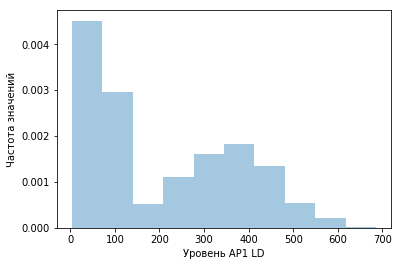

In [9]:
sns.distplot(X_train[X_train['days']==30].AP1, bins=10, kde=False, norm_hist=True)
plt.xlabel('Уровень AP1 LD')
plt.ylabel('Частота значений')
plt.savefig('Hist of AP1_LD.svg', format='svg', bbox_inches='tight')

### Real data for analysis

In [10]:
conditions = ['LD', 'SD']

In [11]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [12]:
X_real['LD']

AP1      FD  FTa1  FTa2  FTa3  FTb  FTc    LFY   TFL1a   TFL1c  days
0      2   31.53     2     8   0.9    3    0    6.4  22.021  25.556     9
1      0   47.62     0    11   0.5    7    0   12.1  20.489  25.263    11
2      6   45.41     1    29   0.8    6    0   21.4  27.397  32.982    13
3      5   40.89     5    60  10.2   28    0   56.8  33.074  39.708    15
4     23   79.47     9    50   1.3   12    0   77.1  42.561  32.222    17
5     33   71.69    40    86   2.5   58    0   48.9  54.798  67.895    20
6      1   25.86    10    18   3.4    7    0   16.0   8.314  11.930    22
7     92   43.31    10    68   4.7  127    0   45.1  18.325  25.731    25
8     19   45.20    10    37   2.1   61    0   27.7  15.851  18.713    28
9    355   81.78     6    52  14.8  102   14   50.9  22.232  29.766    30
10   117   36.26     1    16   3.0   13    0   63.7  11.323  15.029    32
11   649   63.59    29    62  90.4  140    0  124.2  24.033  31.462    34
12   691   81.78     6    34   6.8   25    0  126.1  15.465  19.240    37
13  1025  112.37    41   116  32.2   73    2   95.7  16.039  40.877    40

In [13]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [43]
Y_real['SD']['days'] = X_real['SD'].days.tolist()[1:] + [43]

In [14]:
Y_real['LD']

AP1      FD    LFY   TFL1a   TFL1c  days
0      0   47.62   12.1  20.489  25.263    11
1      6   45.41   21.4  27.397  32.982    13
2      5   40.89   56.8  33.074  39.708    15
3     23   79.47   77.1  42.561  32.222    17
4     33   71.69   48.9  54.798  67.895    20
5      1   25.86   16.0   8.314  11.930    22
6     92   43.31   45.1  18.325  25.731    25
7     19   45.20   27.7  15.851  18.713    28
8    355   81.78   50.9  22.232  29.766    30
9    117   36.26   63.7  11.323  15.029    32
10   649   63.59  124.2  24.033  31.462    34
11   691   81.78  126.1  15.465  19.240    37
12  1025  112.37   95.7  16.039  40.877    40
13   223   25.23   25.5  10.577  10.058    43

### STDs

In [16]:
stds = {}
for cond in conditions:
    stds[cond] = pd.read_csv(data_path + f'stds_{cond}.csv')
#     stds[cond] = stds[cond].drop(0)
#     stds[cond] = stds[cond].drop(FTs, axis = 1)

In [17]:
stds['LD']

AP1        FD   FTa1   FTa2  FTa3    FTb    FTc        LFY  \
0    52.408729   5.45405  27.46  16.91   8.5  68.91  36.39   7.297192   
1    52.408729   8.30000  27.46  16.91   8.5  68.91  36.39   7.297192   
2    52.408729   5.45405  27.46  16.91   8.5  68.91  36.39   7.297192   
3    52.408729   5.45405  27.46  16.91   8.5  68.91  36.39   8.700000   
4    52.408729  19.44000  27.46  18.00   8.5  68.91  36.39   7.297192   
5    52.408729  13.56000  27.46  16.91   8.5  68.91  36.39   8.400000   
6    52.408729   5.45405  27.46  16.91   8.5  68.91  36.39   8.700000   
7    89.000000   5.45405  27.46  19.00   8.5  68.91  36.39  19.300000   
8    52.408729   6.73000  27.46  23.00   8.5  68.91  36.39   7.297192   
9   106.000000   5.57000  27.46  24.00  12.0  68.91  36.39   7.297192   
10   52.408729   6.84000  27.46  16.91   8.5  68.91  36.39  42.200000   
11  173.000000   5.45405  27.46  16.91  58.3  68.91  36.39  32.300000   
12  193.000000  23.44000  27.46  16.91   8.5  68.91  36.39  58.500000   
13  332.000000  21.55000  27.46  44.00   8.5  68.91  36.39  45.800000   
14   56.000000   5.45405  27.46  16.91  12.1  68.91  36.39   7.297192   

        TFL1a      TFL1c  
0    2.806716   2.910387  
1    2.806716   2.910387  
2    6.975000   5.556000  
3    2.806716   2.910387  
4   11.898000   2.910387  
5   11.722000   7.368000  
6    2.806716   2.910387  
7    2.806716   4.152000  
8    2.806716   2.749000  
9    2.806716   2.910387  
10   2.806716   2.910387  
11   4.748000   4.561000  
12   2.806716   2.910387  
13   2.806716  19.123000  
14   2.806716   2.910387

### Data visualization 

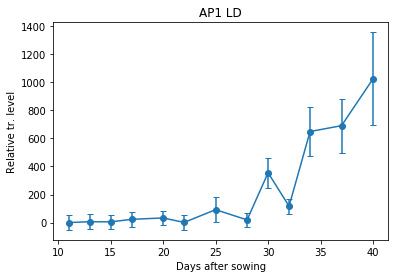

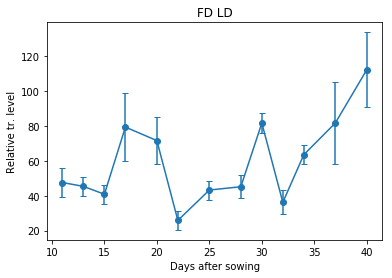

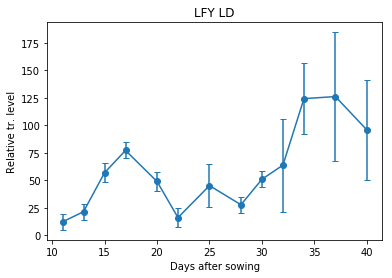

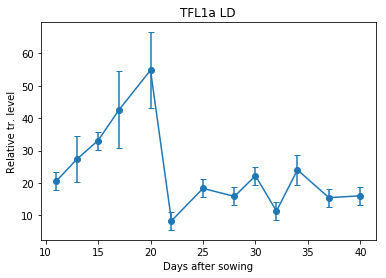

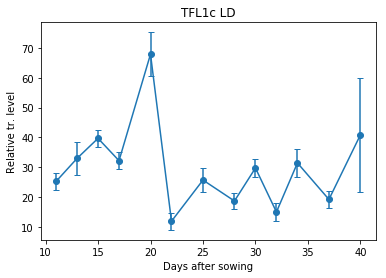

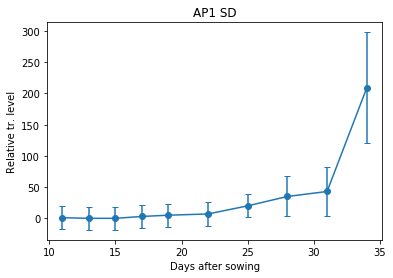

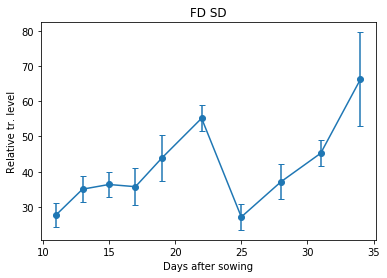

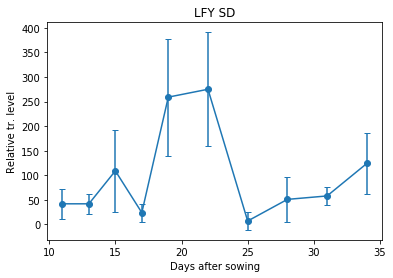

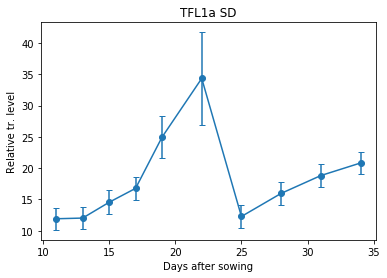

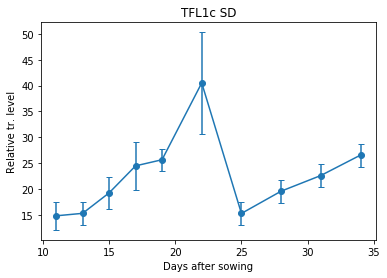

In [23]:
for cond in conditions:
    for g in targets:
        plt.errorbar(Y_real[cond].days, Y_real[cond][g], stds[cond][g][1:], fmt='-o', capsize=3)
        
        plt.title(f'{g} {cond}')
        plt.xlabel('Days after sowing')
        plt.ylabel('Relative tr. level')
        
        plt.savefig(f'vector/datavis/{g}_{cond}')
        plt.show()

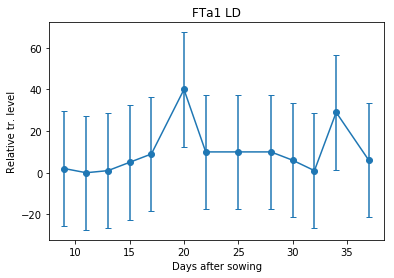

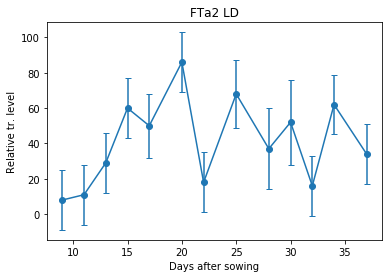

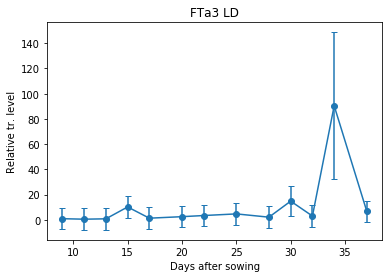

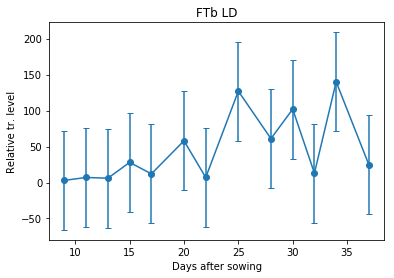

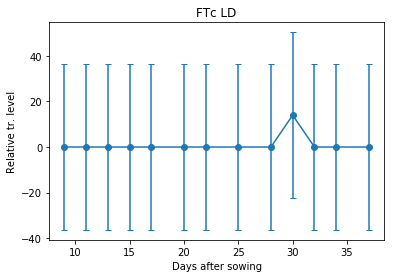

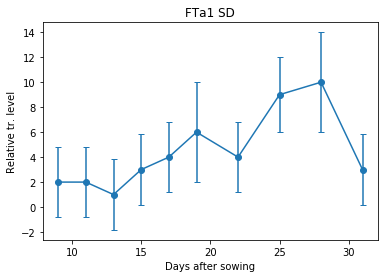

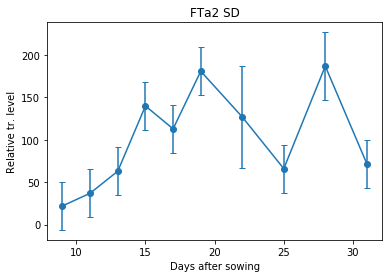

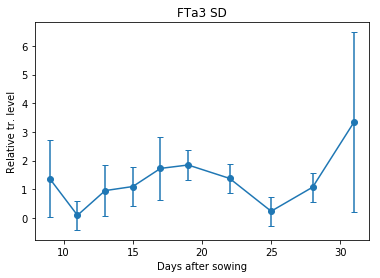

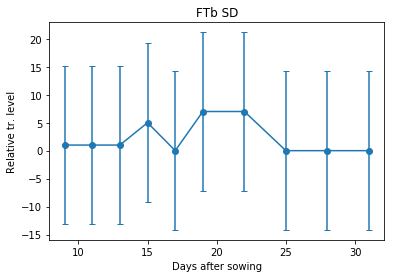

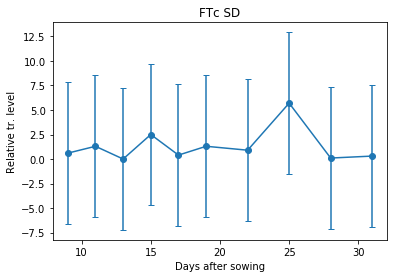

In [21]:
for cond in conditions:
    for g in FTs:
        plt.errorbar(X_real[cond].days, X_real[cond][g], stds[cond][g][:-1], fmt='-o', capsize=3)
        
        plt.title(f'{g} {cond}')
        plt.xlabel('Days after sowing')
        plt.ylabel('Relative tr. level')
        
        plt.savefig(f'vector/datavis/{g}_{cond}')
        plt.show()

## Check the data

In [18]:
X_train.tail()

AP1         FD       FTa1        FTa2      FTa3        FTb  \
11995  30.209853  61.955310  18.721259  186.281459  1.912255   8.667483   
11996  47.075529  55.248155   9.813249  178.989122  1.083712   6.133013   
11997  36.415940  27.963097  15.303447  237.106537  1.198817  21.505152   
11998  57.930569  21.084907  18.639742  203.360568  1.072865  24.687854   
11999  35.309307  59.763766  13.986615  115.699650  1.022327   6.571967   

             FTc        LFY      TFL1a      TFL1c  days  
11995   3.759575  25.770062  15.716764  19.738242    40  
11996  10.378049  44.057749  17.694609  23.544449    40  
11997  14.214631  29.591344   9.711996  30.770479    40  
11998  24.119667  73.255858  15.482936  12.017171    40  
11999  17.831809  20.125093  11.624173  16.549178    40

In [19]:
X_train.days.value_counts()

31    750
15    750
30    750
22    750
37    750
13    750
28    750
20    750
19    750
11    750
34    750
25    750
17    750
9     750
40    750
32    750
Name: days, dtype: int64

In [20]:
Y_train.tail()

AP1         FD        LFY      TFL1a      TFL1c  days
11995  19.533267  21.990897  26.248205  10.926765  19.471704    43
11996  36.189393  38.007495  26.393600  13.146408  10.911093    43
11997  34.188660  16.973848   1.943543   7.586845  11.713444    43
11998  42.993622  35.083533   4.338056  10.537851  22.154665    43
11999  17.110908  23.656439  10.889699  12.172244  12.494907    43

In [23]:
days = list(set(X_test.days.values))
days.append(43)
days.sort()
days

[9, 11, 13, 15, 17, 19, 20, 22, 25, 28, 30, 31, 32, 34, 37, 40, 43]

In [24]:
X = X_train.drop('days', axis=1)
Y = Y_train.drop('days', axis=1)

In [25]:
targets = Y.columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [26]:
X_test.tail()

AP1         FD       FTa1        FTa2      FTa3        FTb  \
3995  43.992538  45.496518   8.750738  180.115373  2.170648  36.792411   
3996  33.708475  40.466899  15.178179  214.741555  2.505692  19.938401   
3997  50.394488  46.987970  16.139397  225.195998  0.722020   6.377998   
3998  30.952334  39.422014  14.474484  227.593981  3.114433  23.102190   
3999  49.776266  38.360473   9.533853  149.393554  0.198419  19.891823   

            FTc        LFY      TFL1a      TFL1c  days  
3995   6.194787  39.791331  17.733139  26.364552    40  
3996   8.669307  32.355092  12.470181  13.679263    40  
3997  19.176535  93.706460  14.547931  15.716096    40  
3998   6.336335  77.760460  11.916706  21.892518    40  
3999  22.186592  30.933516  16.564095  21.371202    40

# Random forest

## Model building

In [27]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

### Rough tuning

In [28]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [20, 50, 100, 300],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 8, 20, None]
}

In [29]:
gs = GridS(model, grid, cv)

In [30]:
gs.fit(X.values, Y.values)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [20, 50, 100, 300], 'min_samples_leaf': [10, 20, 50, 100], 'max_depth': [5, 8, 20, None]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [31]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 100}

### Fine tuning (?)

In [39]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [100],
    'min_samples_leaf': [10, 50, 100],
    'max_depth': [15, 20, 25, None]
}

In [40]:
gs = GridS(model, grid, cv)

In [41]:
gs.fit(X.values, Y.values)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100], 'min_samples_leaf': [10, 50, 100], 'max_depth': [15, 20, 25, None]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [42]:
gs.best_params_

{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 100}

Get the model with best score on the cross-validation:

In [32]:
best_model = gs.best_estimator_

### Save the model

In [26]:
with open('cache/Overfitted_Random_forest.md', 'wb') as ouf:
    dill.dump(best_model, ouf)

## Make predictions

In [33]:
predictions_train = best_model.predict(X.values)
predictions_test = best_model.predict(X_test.drop('days', axis=1).values)

## Evaluating

In [34]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets, )
    return df

In [35]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0], s=3):
    plt.scatter(true_values, predictions, s=s)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    plt.savefig(results_path + current_target + '_' + data_type + '.svg', bbox_inches='tight', format='svg')
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [36]:
print_scores(Y, predictions_train)

MSE  NRMSE    R2     r
AP1    6961.60  0.043  0.88  0.94
FD      119.88  0.059  0.79  0.89
LFY    1693.41  0.062  0.71  0.85
TFL1a    27.44  0.051  0.85  0.92
TFL1c    35.87  0.066  0.83  0.91

Scores on test:

In [37]:
print_scores(Y_test.drop('days', axis=1), predictions_test)

MSE  NRMSE    R2     r
AP1    10860.21  0.056  0.82  0.90
FD       144.46  0.071  0.75  0.86
LFY     2234.40  0.081  0.59  0.77
TFL1a     33.11  0.059  0.81  0.90
TFL1c     40.39  0.069  0.81  0.90

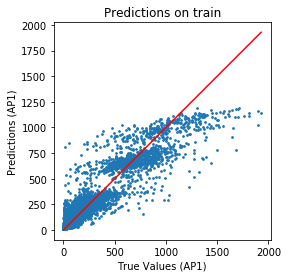

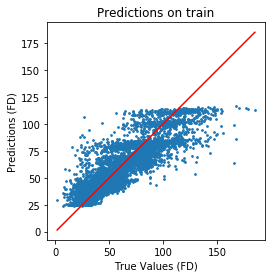

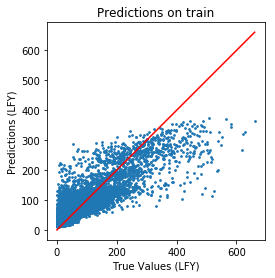

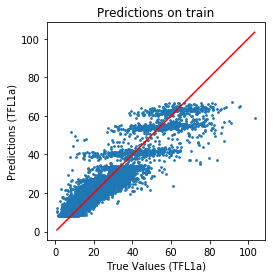

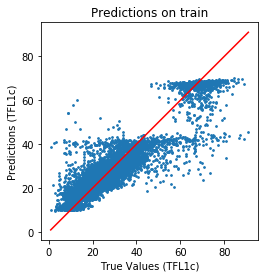

In [38]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train[:, i], data_type='train', current_target=targets[i])

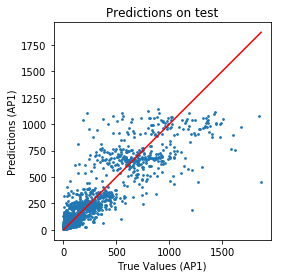

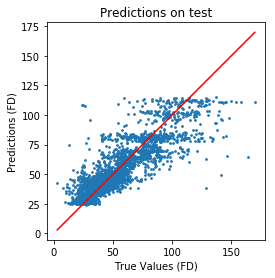

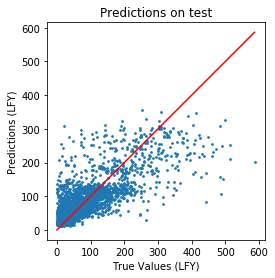

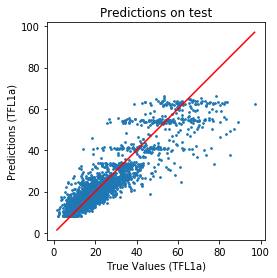

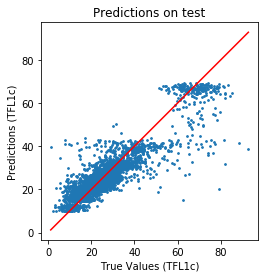

In [39]:
for i in range(5):
    comparsion_plot(Y_test.drop('days', axis=1).iloc[:, i], predictions_test[:, i], data_type='test', current_target=targets[i])

## Feature importances

In [41]:
genes = X.columns
genes

Index(['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a',
       'TFL1c'],
      dtype='object')

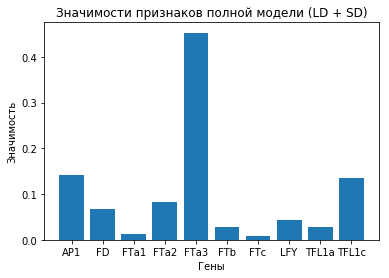

In [42]:
plt.bar(x = genes, height = best_model.feature_importances_)
plt.title('Значимости признаков полной модели (LD + SD)')
plt.xlabel('Гены')
plt.ylabel('Значимость')
plt.savefig(results_path + 'feature_importances')

# Real data

In [63]:
def time_long_plot(true_values, predicted, condition = 'LD', predict_method = 'static'):
    
    for i in range(5):
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition][targets].iloc[:,i][1:],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(true_values['days'], predicted.iloc[:, i].values, '-')
        
        plt.title(targets[i] + ' ' + condition + f' ({predict_method} prediction method)')
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions', 'true values'])
        
        fig_path = results_path + predict_method + '/' + condition + '/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_pred_on_real.svg', 
                    bbox_inches='tight', format='svg')
        plt.show()

In [44]:
def predict(data):
    
    predictions = pd.DataFrame(best_model.predict(data.values), columns = targets)
     
    return predictions

## Static

In [45]:
predictions_real = {}
predictions_real['LD'] = best_model.predict(X_real['LD'].drop('days', axis=1).values)
predictions_real['SD'] = best_model.predict(X_real['SD'].drop('days', axis=1).values)

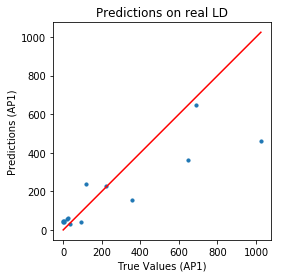

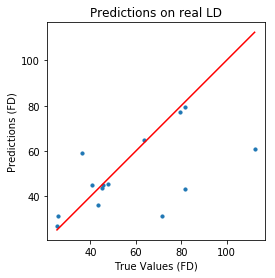

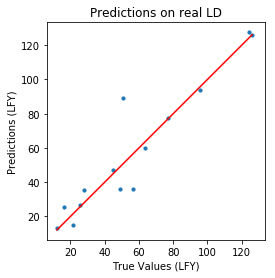

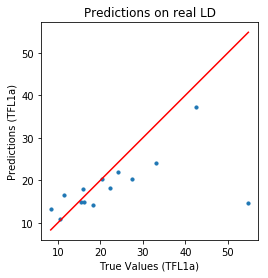

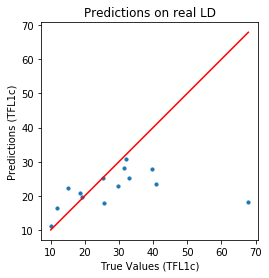

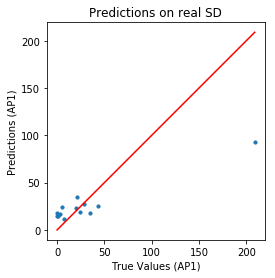

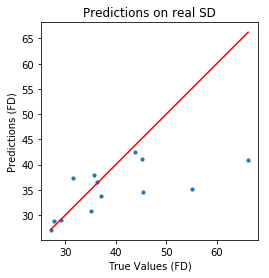

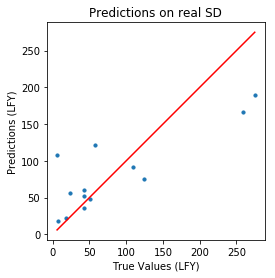

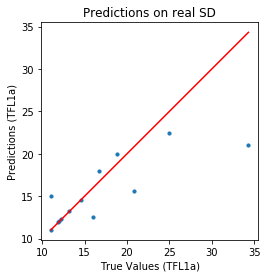

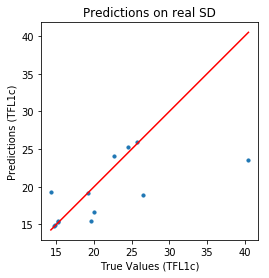

In [46]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond][:, i], data_type='real ' + cond, current_target=targets[i], s=10)

In [48]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

MSE  NRMSE    R2     r
AP1    33286.47  0.178  0.67  0.89
FD       453.39  0.189  0.23  0.58
LFY      162.00  0.101  0.88  0.94
TFL1a    133.83  0.211  0.15  0.52
TFL1c    227.09  0.222 -0.11  0.32

In [47]:
print_scores(Y_real['SD'].drop('days', axis=1), predictions_real['SD'])

MSE  NRMSE    R2     r
AP1    1194.35  0.165  0.58  0.96
FD       95.51  0.148  0.20  0.65
LFY    2667.28  0.188  0.64  0.84
TFL1a    18.47  0.125  0.56  0.82
TFL1c    31.01  0.137  0.37  0.67

In [49]:
for cond in conditions:
    predictions_real[cond] = pd.DataFrame(predictions_real[cond], columns=targets)

In [60]:
len(stds['LD'][targets].iloc[:,1][1:])

14

In [59]:
len(Y_real['LD'].iloc[:,1])

14

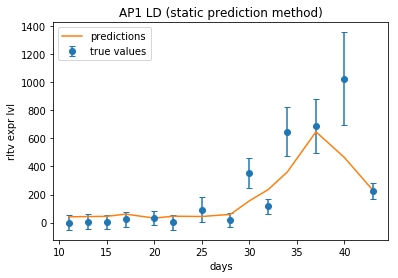

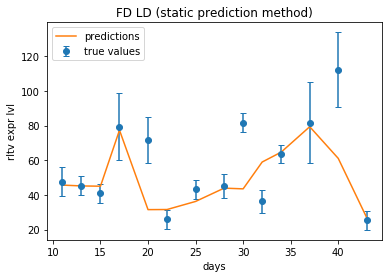

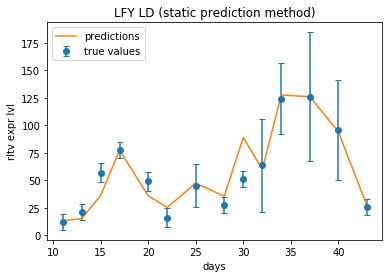

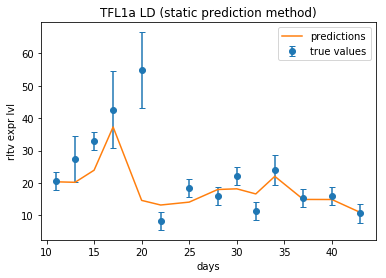

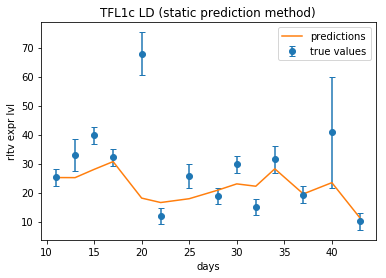

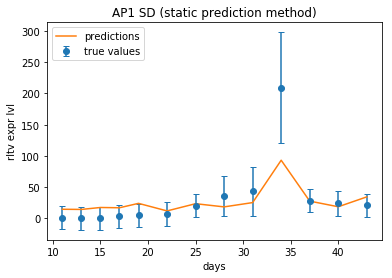

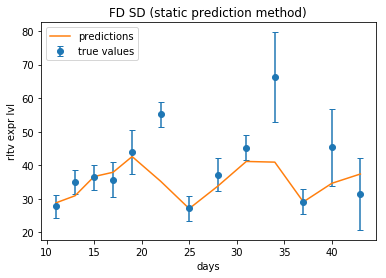

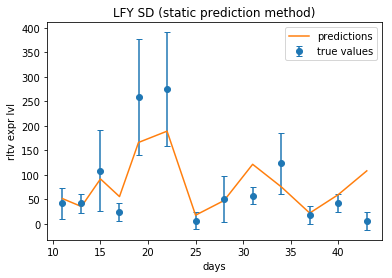

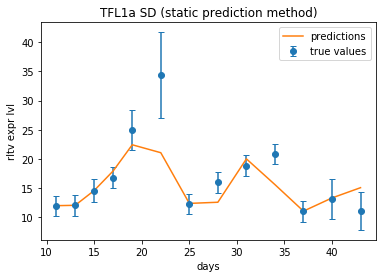

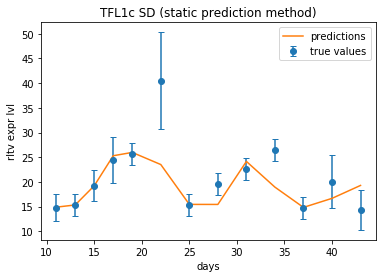

In [64]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

## Dynamic

In [65]:
predictions_real = {}

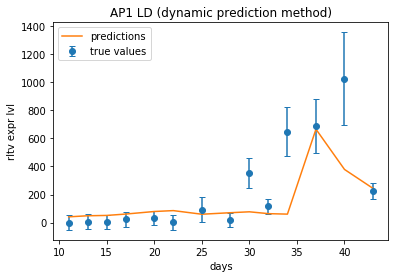

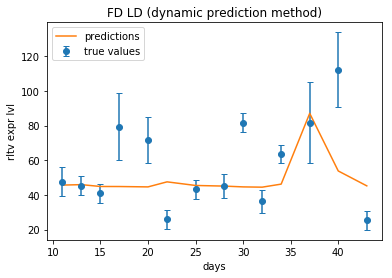

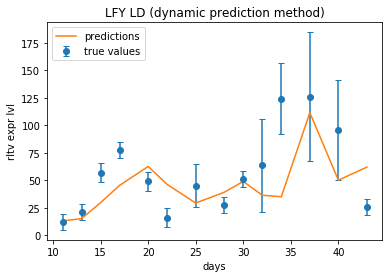

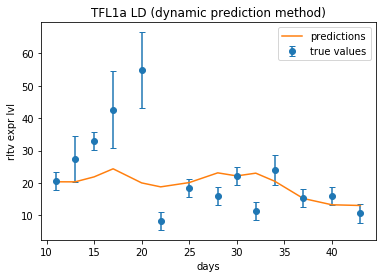

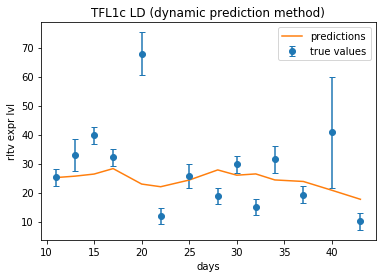

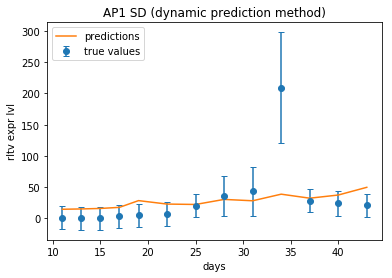

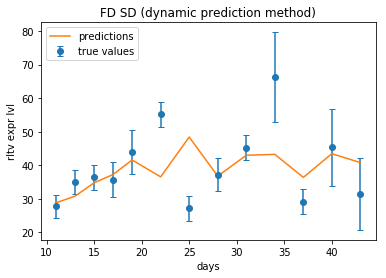

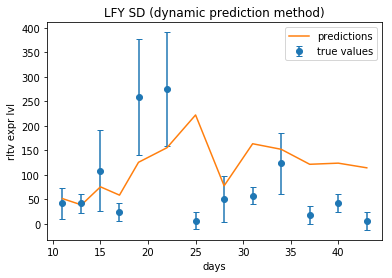

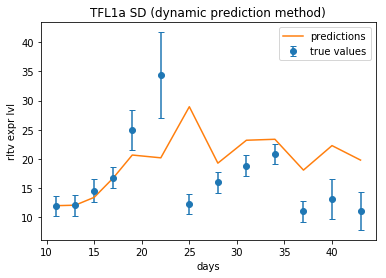

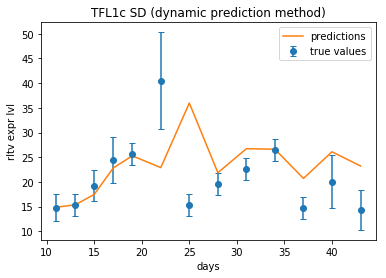

In [66]:
for cond in conditions:

    X_temp = X_real[cond].drop('days', axis = 1)

    predictions_real[cond] = pd.DataFrame(columns=targets)

    for i in X_real[cond].index:
        current_predictions = predict(X_temp.loc[[i]])
        predictions_real[cond] = predictions_real[cond].append(current_predictions, ignore_index = True)
        X_temp[targets] = current_predictions.values[0]

    time_long_plot(Y_real[cond], predictions_real[cond], cond, 'dynamic')

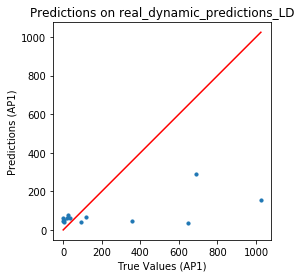

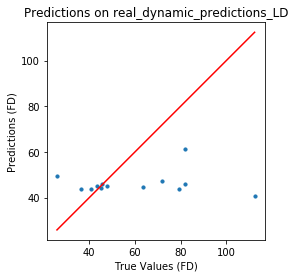

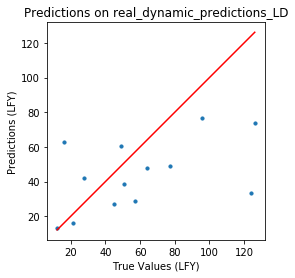

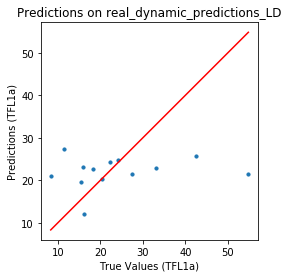

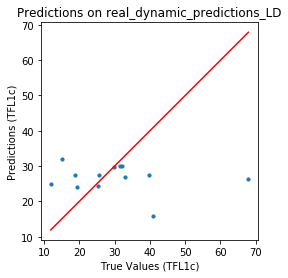

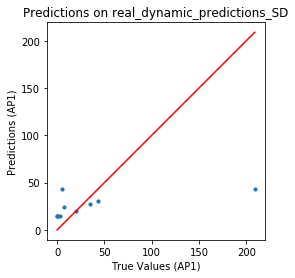

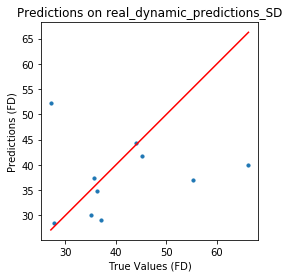

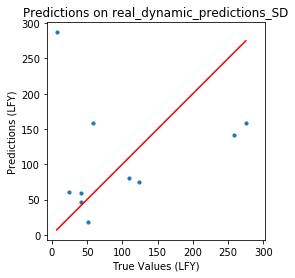

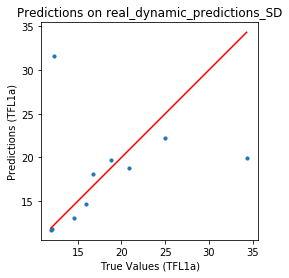

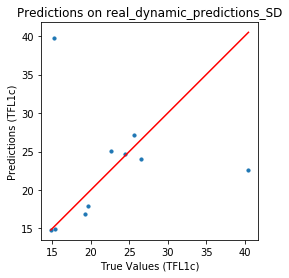

In [19]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real_dynamic_predictions_' + cond, current_target=targets[i], s=10)

In [13]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions.values, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions.values, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.values.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets, )
    return df

In [70]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
             MSE    R2     r
AP1    108042.67 -0.00  0.62
FD        741.92 -0.34  0.05
LFY      1251.21  0.06  0.48
TFL1a     158.05 -0.01  0.17
TFL1c     239.23 -0.24 -0.19
SD
            MSE    R2     r
AP1     3010.59  0.18  0.65
FD       175.27 -0.31  0.12
LFY    12192.61 -0.49  0.13
TFL1a     59.81 -0.34  0.23
TFL1c     94.12 -0.75  0.09


In [14]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

MSE  NRMSE    R2     r
AP1    108042.67  0.321 -0.00  0.62
FD        741.92  0.242 -0.34  0.05
LFY      1251.21  0.281  0.06  0.48
TFL1a     158.05  0.229 -0.01  0.17
TFL1c     239.23  0.228 -0.24 -0.19

In [15]:
print_scores(Y_real['SD'].drop('days', axis=1), predictions_real['SD'])

MSE  NRMSE    R2     r
AP1     3010.59  0.263  0.18  0.65
FD       175.27  0.200 -0.31  0.12
LFY    12192.61  0.402 -0.49  0.13
TFL1a     59.81  0.225 -0.34  0.23
TFL1c     94.12  0.240 -0.75  0.09

# Knock out simulation

## Methods definitions

In [ ]:
# def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic'):
#     x_axis = true_values['days']
    
#     for i in range(5):        
#         plt.plot(x_axis, true_values.iloc[:,i].values, 'o')
#         plt.plot(x_axis, predicted.iloc[:, i], '--')
#         plt.plot(x_axis, pred_for_ko.iloc[:, i], '-')
        
#         if type(KO_gene) == type(''):
#             KO_name = KO_gene
#         else:            
#             KO_name = '_'.join(KO_gene)

#         plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
#         plt.xlabel('days')
#         plt.ylabel('rltv expr lvl')
#         plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
#         plt.savefig(results_path + f'{predict_method}/KOs/{targets[i]}/{targets[i]}_{condition}_with_{KO_gene}_KO.png', 
#                     bbox_inches='tight', dpi=300)
#         plt.show()

In [81]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic'):
    x_axis = true_values['days']
    
    for i in range(5):        
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(x_axis, predicted.iloc[:, i], '--')
        plt.plot(x_axis, pred_for_ko[:, i], '-')
        
        if type(KO_gene) == type(''):
            KO_name = KO_gene
        else:            
            KO_name = '_'.join(KO_gene)

        plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions on WT', 'predictions with KO', 'true values'])
        
        if type(KO_gene) != type(''):
            KO_number = len(KO_gene)
        else:
            KO_number = 1
        
        fig_path = results_path + f'{predict_method}/KOs/{targets[i]}/{KO_number}/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_with_{KO_gene}_KO.svg', 
                    bbox_inches='tight', format = 'svg')
        plt.show()

## KO Iterations set

In [72]:
targets_with_cond = [name + '_LD' for name in targets]
targets_with_cond = targets_with_cond + [name + '_SD' for name in targets]

In [73]:
targets_with_cond

['AP1_LD',
 'FD_LD',
 'LFY_LD',
 'TFL1a_LD',
 'TFL1c_LD',
 'AP1_SD',
 'FD_SD',
 'LFY_SD',
 'TFL1a_SD',
 'TFL1c_SD']

In [75]:
genes = X_real['LD'].drop('days', axis=1).columns.tolist()

In [107]:
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [77]:
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [85]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

In [97]:
def FTs_combos(massive = FTs, number = 2):
    
    FTset = []
    comb = list(itertools.combinations(massive, number))
    
    for c in comb:
        FTset.append(list(c))

    return FTset

In [98]:
FT_pairs = FTs_combos(FTs, 2)
FT_pairs

[['FTa1', 'FTa2'],
 ['FTa1', 'FTa3'],
 ['FTa1', 'FTb'],
 ['FTa1', 'FTc'],
 ['FTa2', 'FTa3'],
 ['FTa2', 'FTb'],
 ['FTa2', 'FTc'],
 ['FTa3', 'FTb'],
 ['FTa3', 'FTc'],
 ['FTb', 'FTc']]

In [99]:
FT_trios = FTs_combos(FTs, 3)
FT_trios

[['FTa1', 'FTa2', 'FTa3'],
 ['FTa1', 'FTa2', 'FTb'],
 ['FTa1', 'FTa2', 'FTc'],
 ['FTa1', 'FTa3', 'FTb'],
 ['FTa1', 'FTa3', 'FTc'],
 ['FTa1', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb'],
 ['FTa2', 'FTa3', 'FTc'],
 ['FTa2', 'FTb', 'FTc'],
 ['FTa3', 'FTb', 'FTc']]

In [100]:
FT_quads = FTs_combos(FTs, 4)
FT_quads

[['FTa1', 'FTa2', 'FTa3', 'FTb'],
 ['FTa1', 'FTa2', 'FTa3', 'FTc'],
 ['FTa1', 'FTa2', 'FTb', 'FTc'],
 ['FTa1', 'FTa3', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb', 'FTc']]

In [101]:
KO_iterations = [targets, FTs, FT_pairs, FT_trios, FT_quads]

## KO simulations

In [84]:
AUC = pd.DataFrame(0, index=targets_with_cond, columns=['WT'])

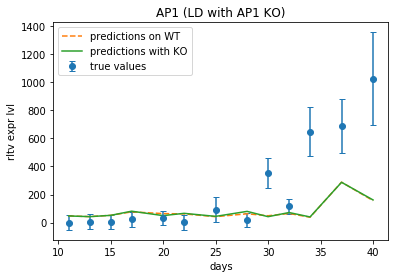

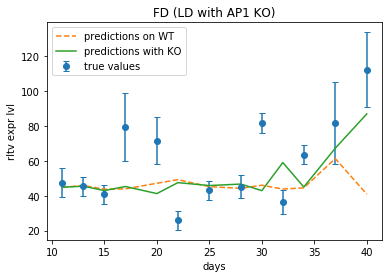

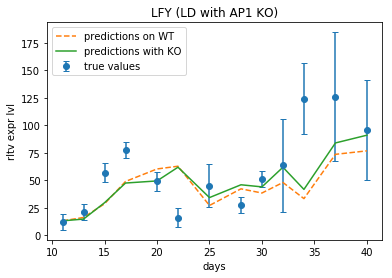

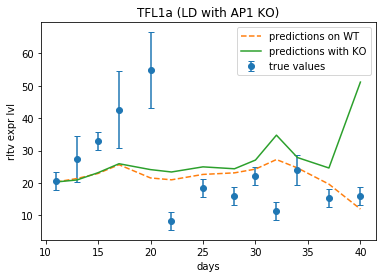

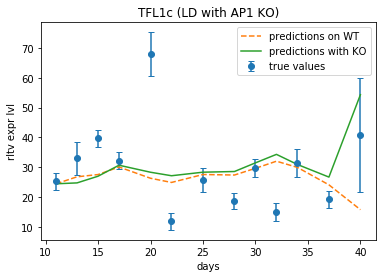

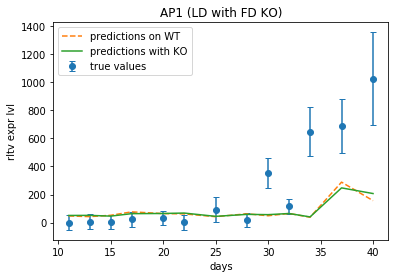

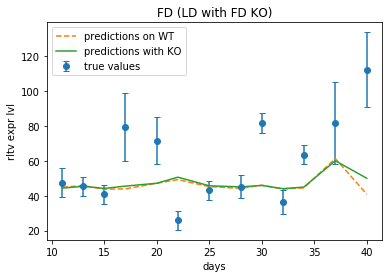

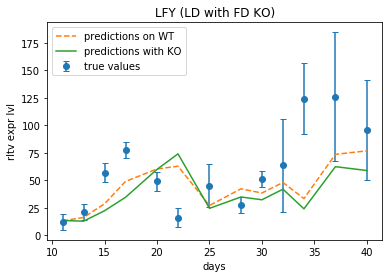

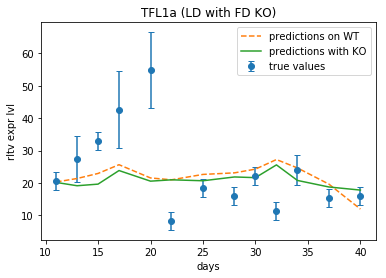

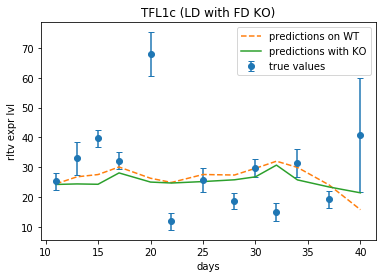

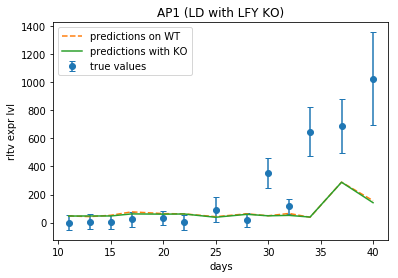

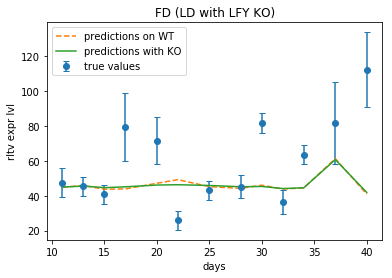

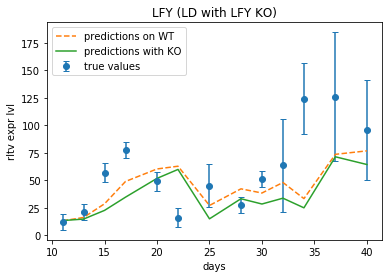

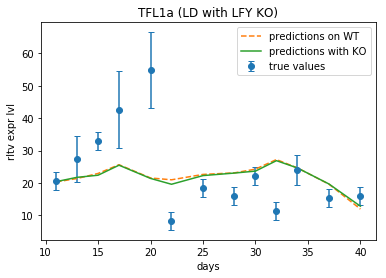

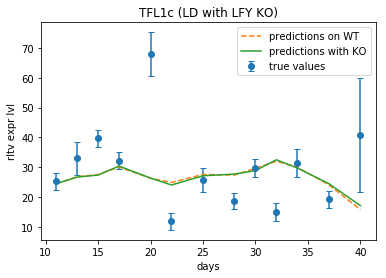

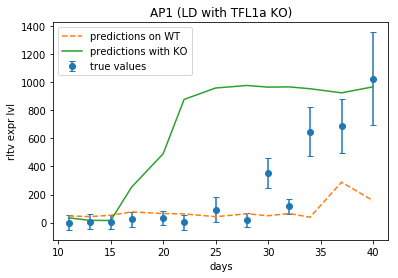

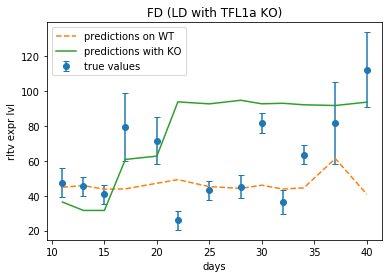

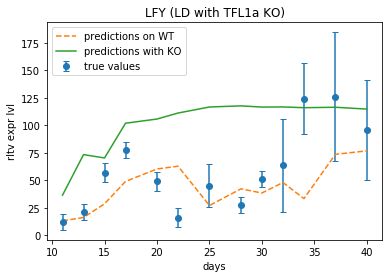

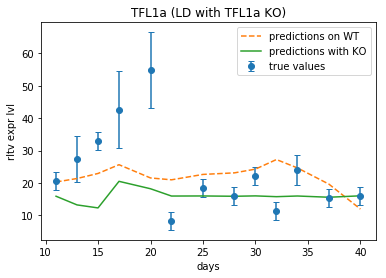

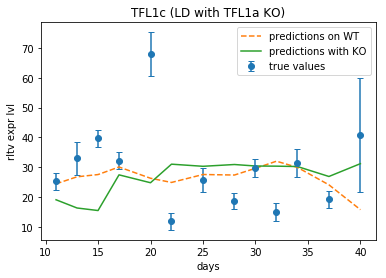

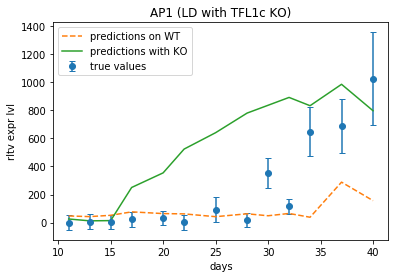

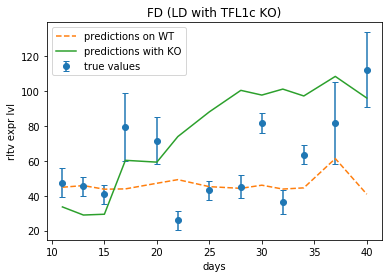

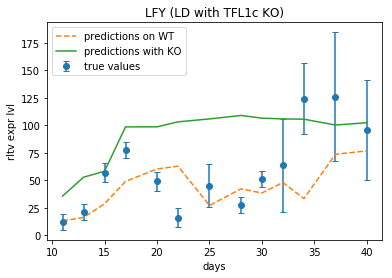

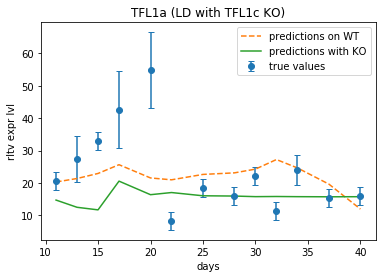

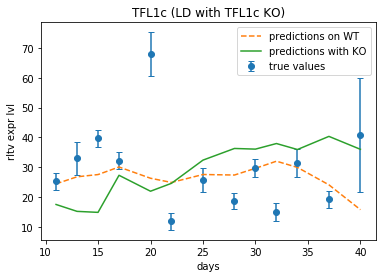

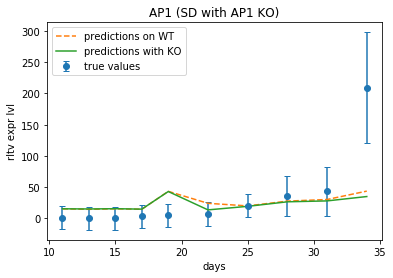

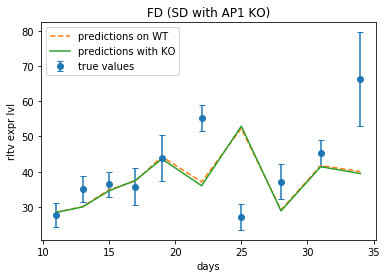

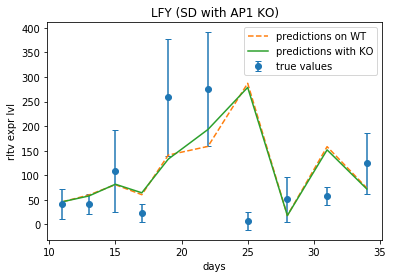

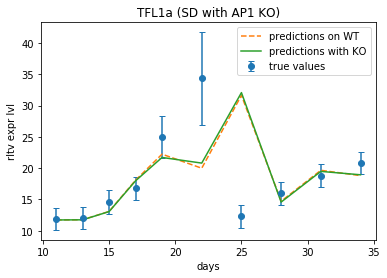

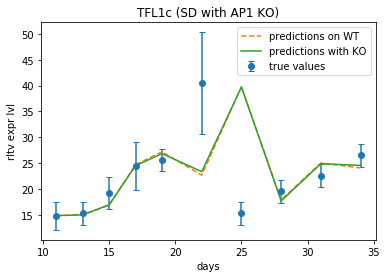

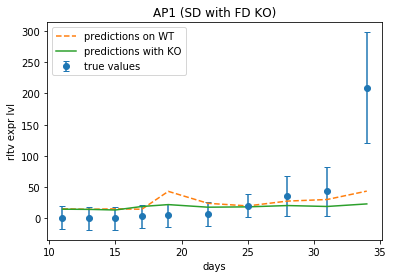

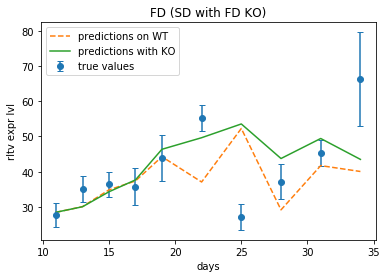

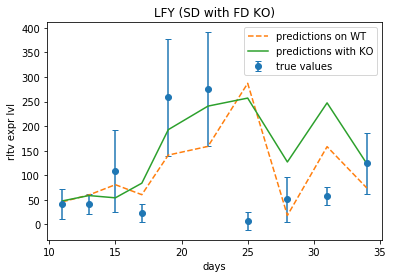

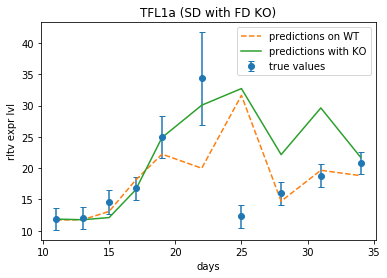

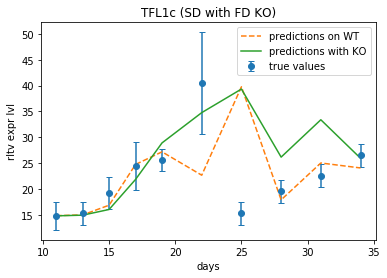

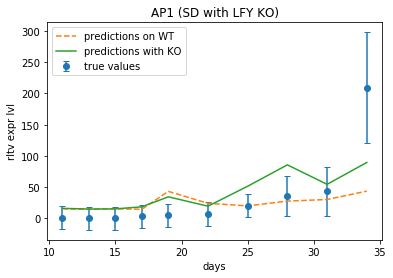

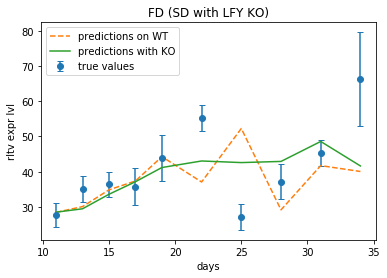

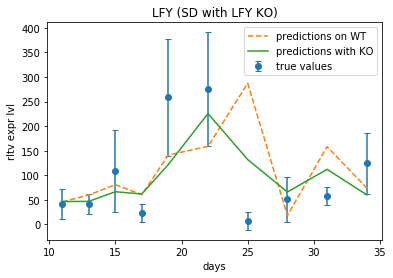

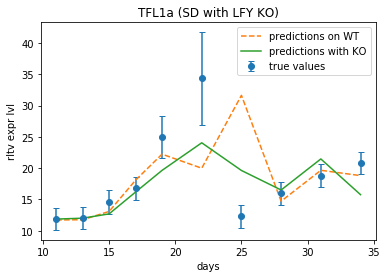

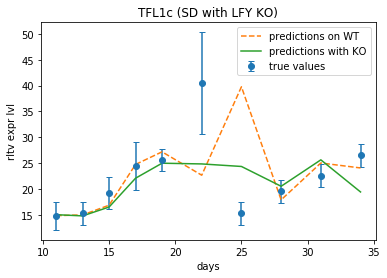

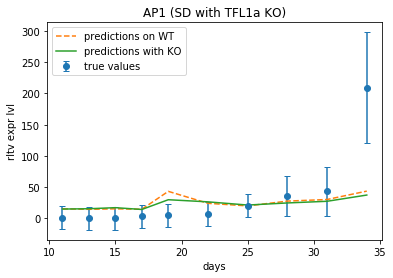

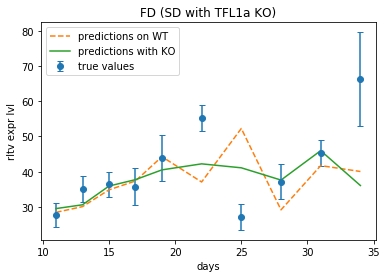

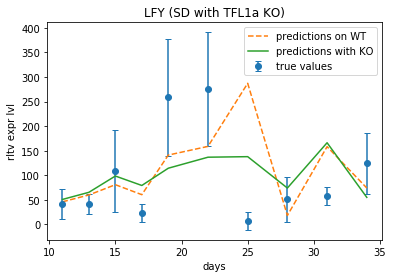

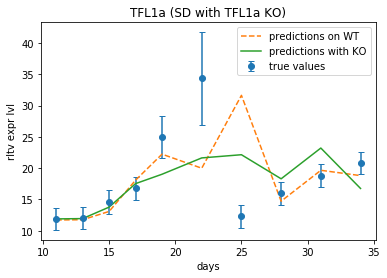

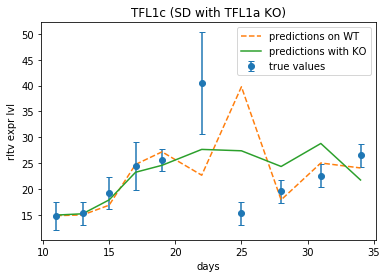

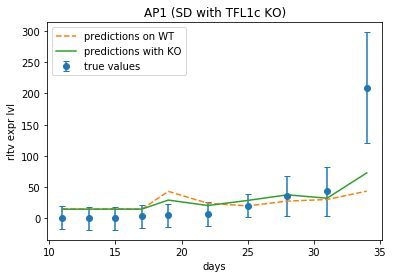

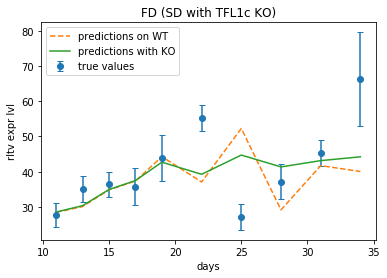

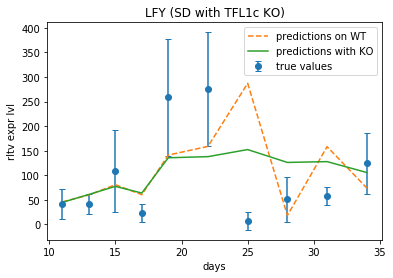

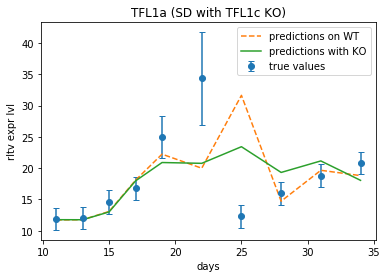

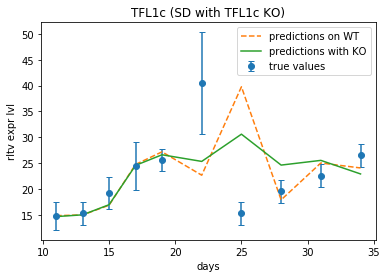

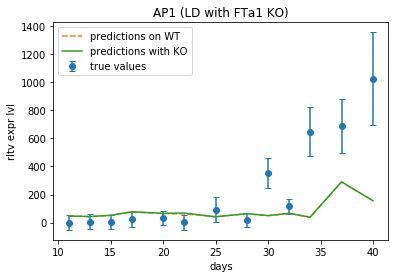

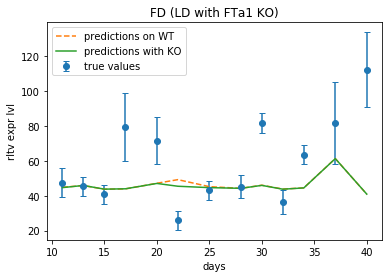

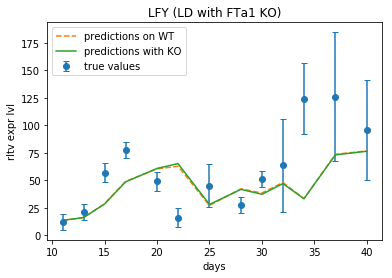

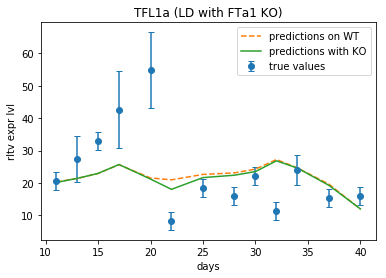

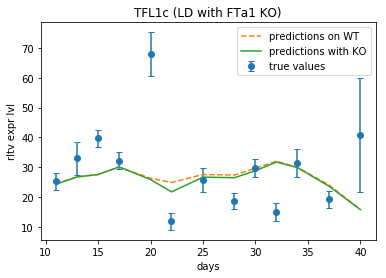

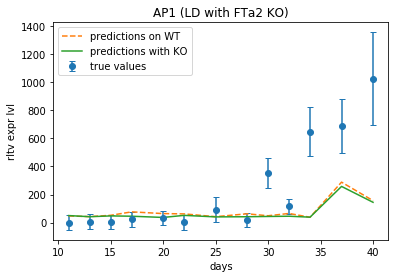

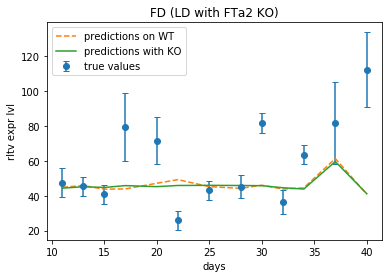

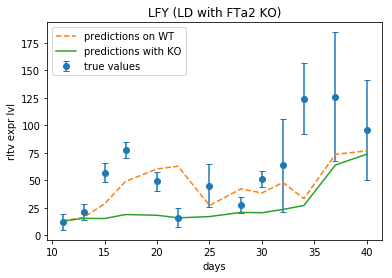

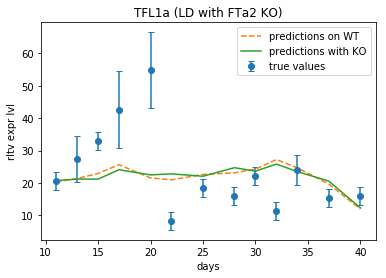

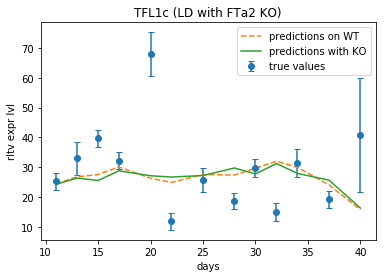

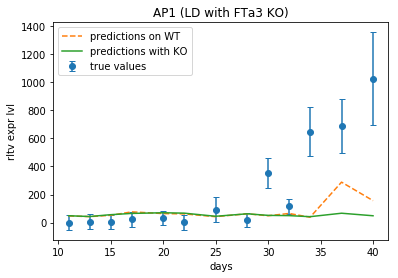

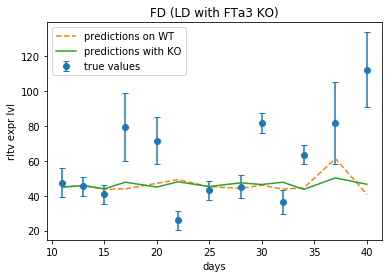

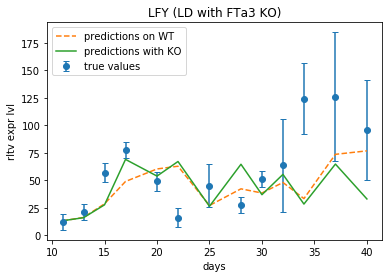

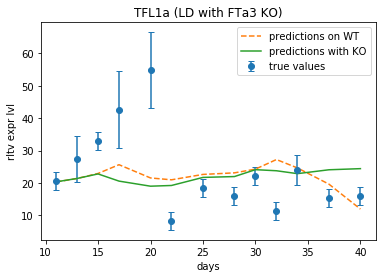

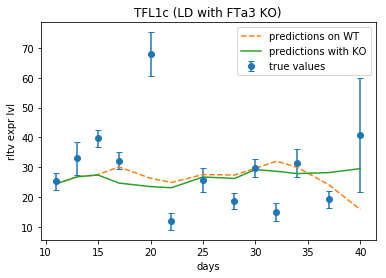

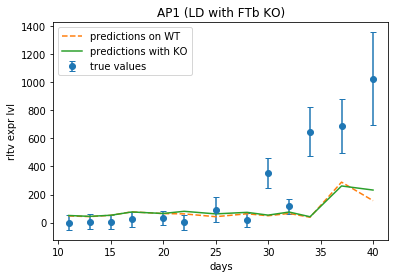

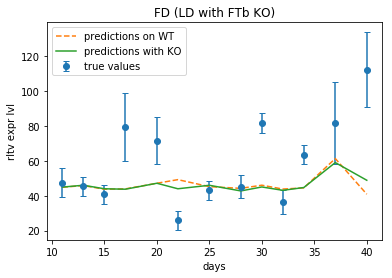

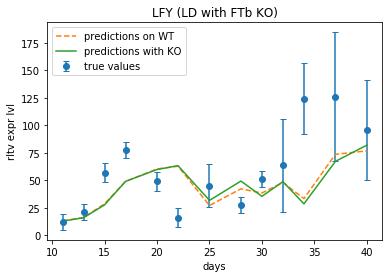

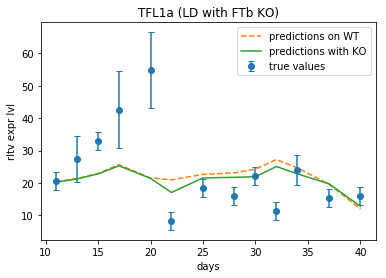

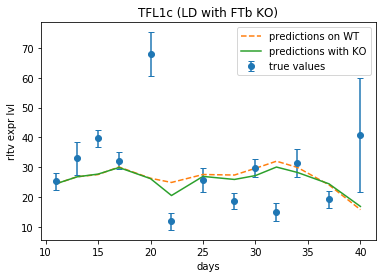

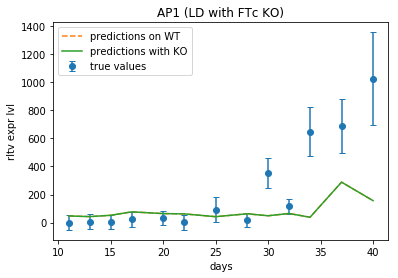

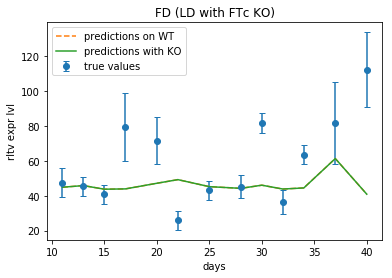

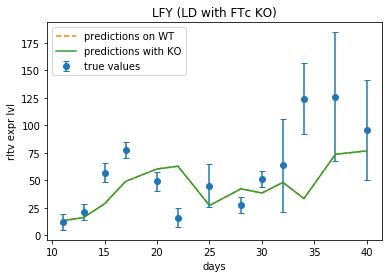

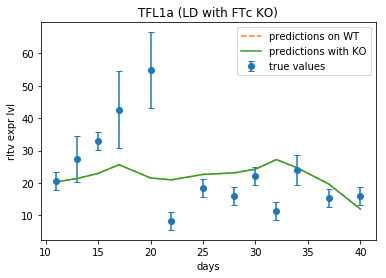

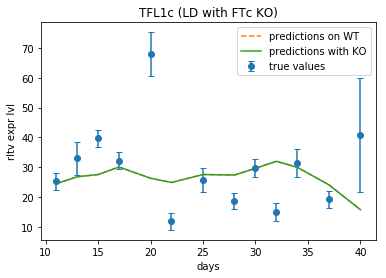

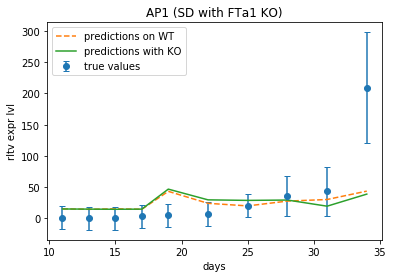

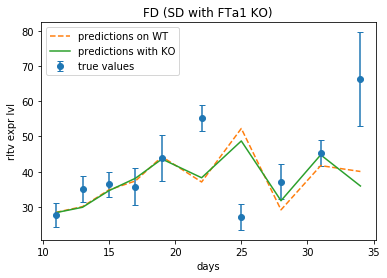

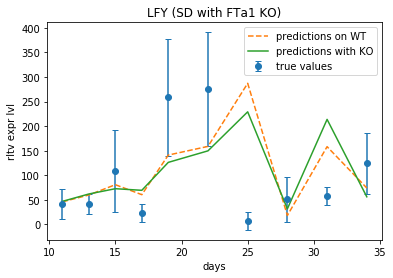

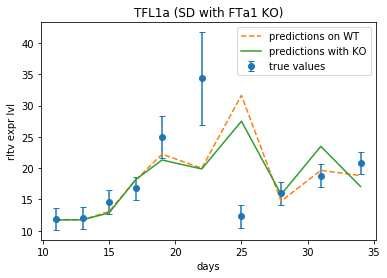

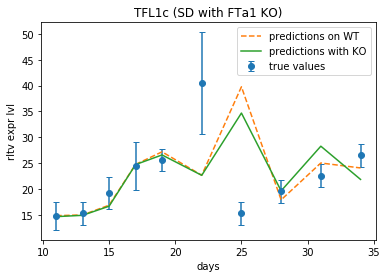

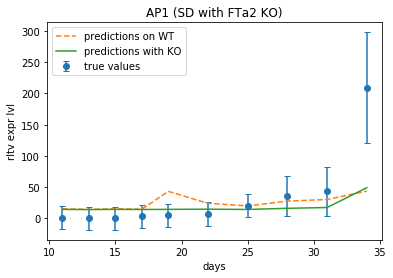

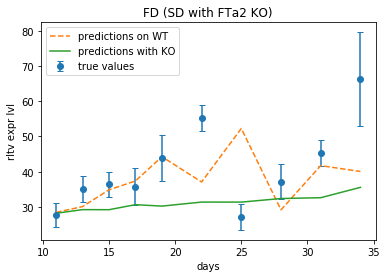

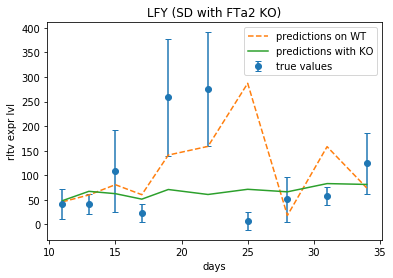

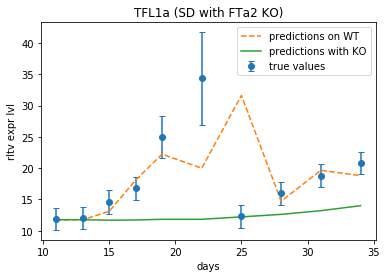

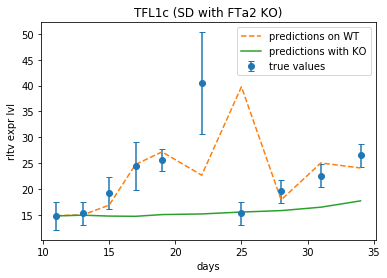

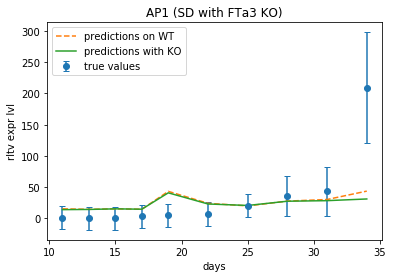

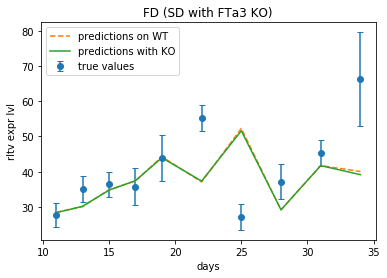

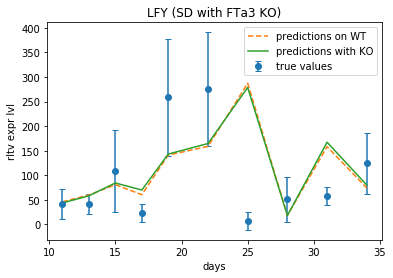

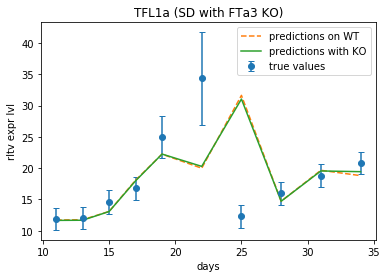

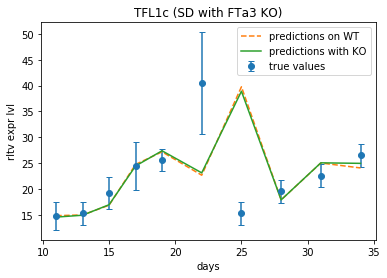

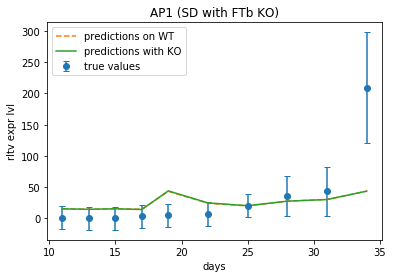

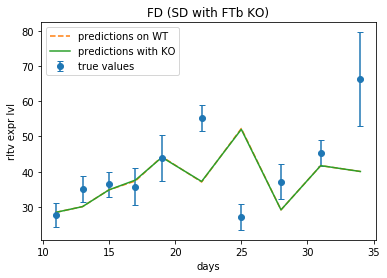

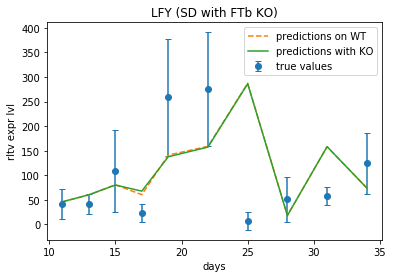

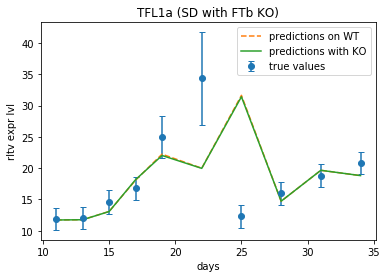

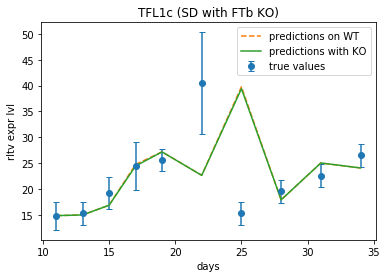

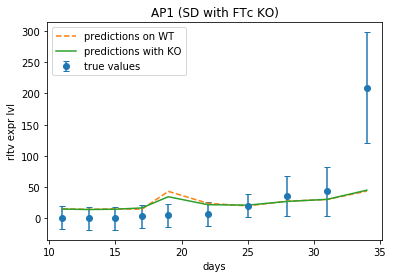

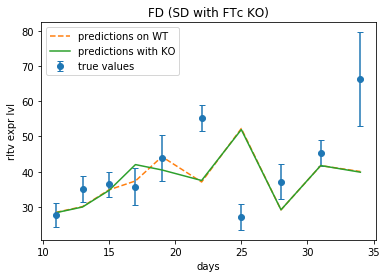

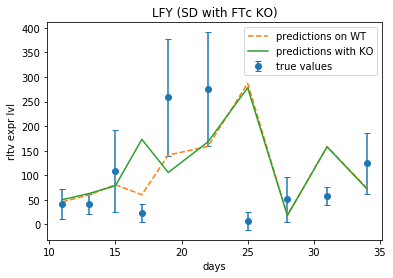

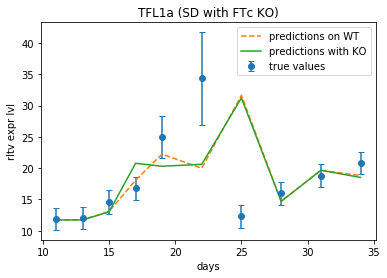

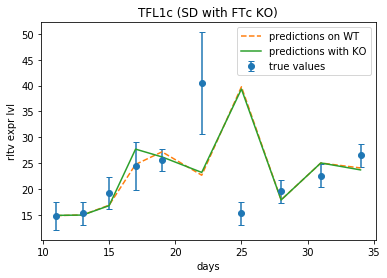

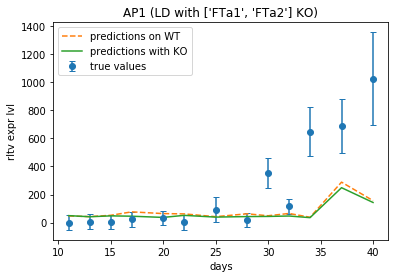

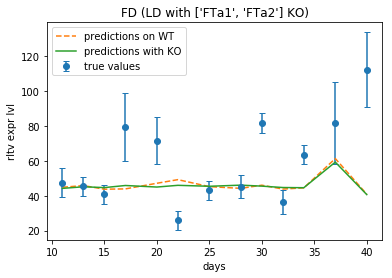

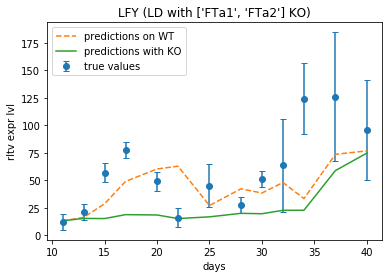

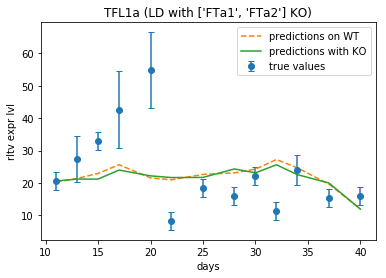

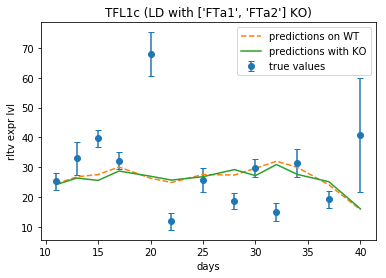

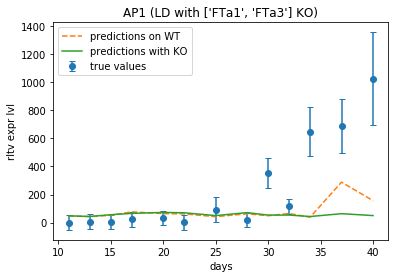

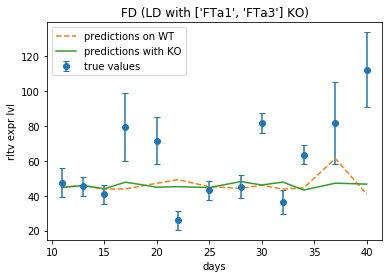

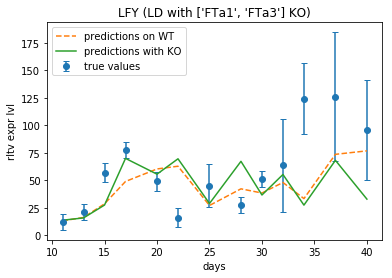

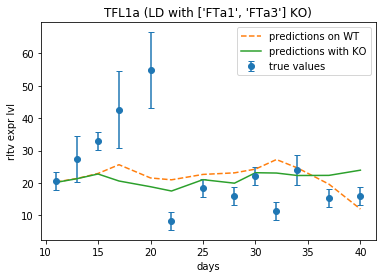

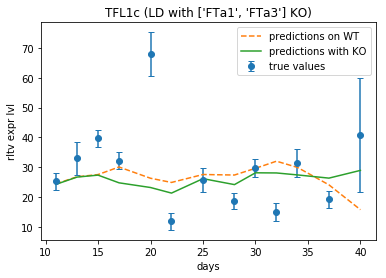

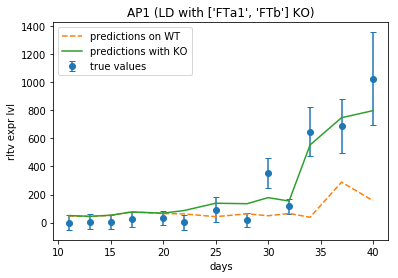

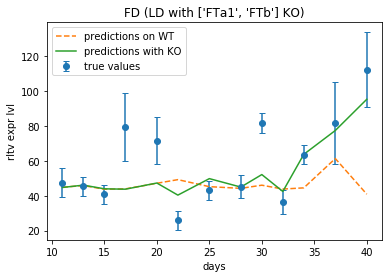

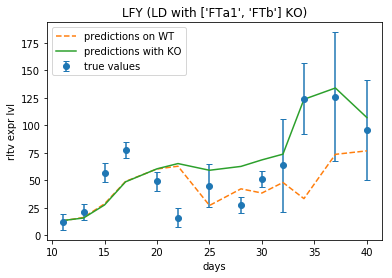

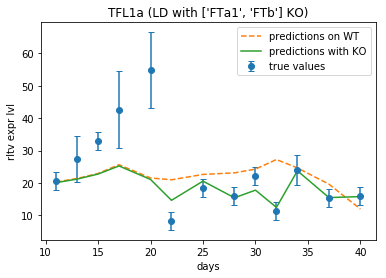

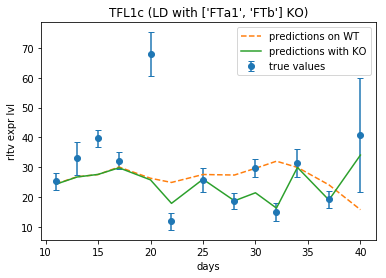

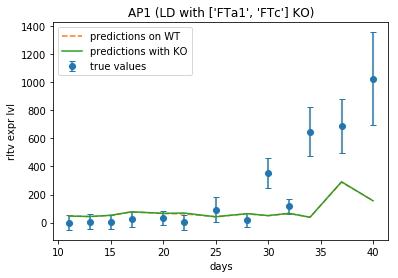

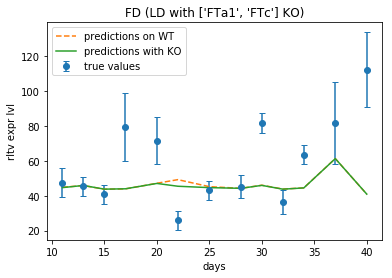

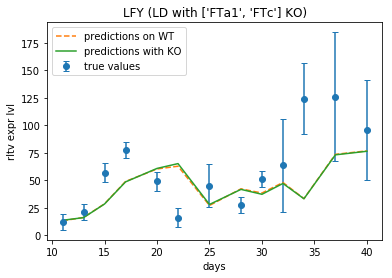

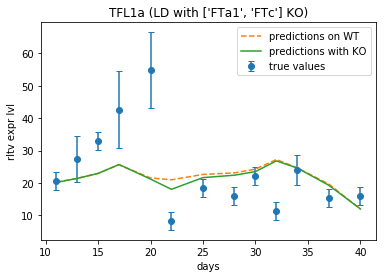

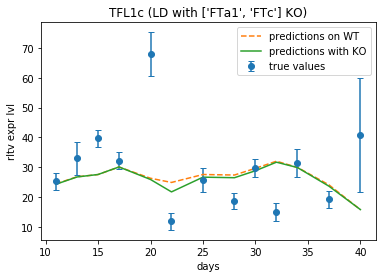

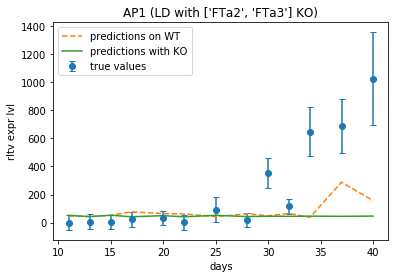

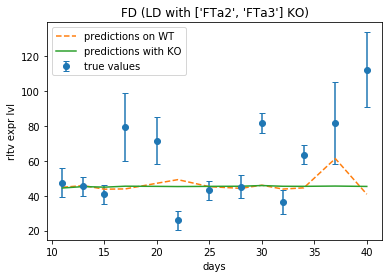

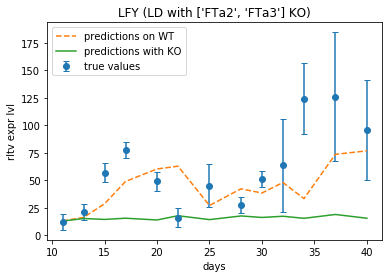

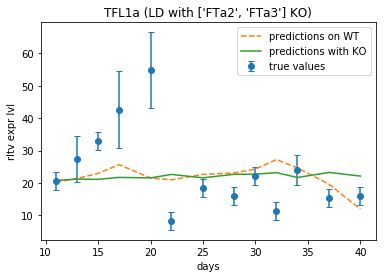

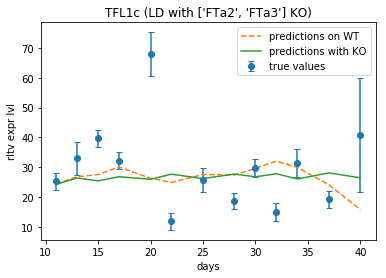

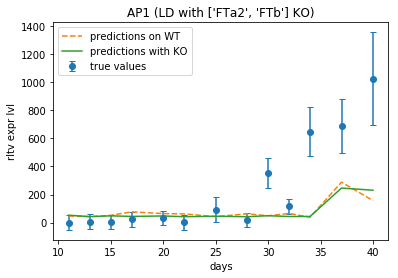

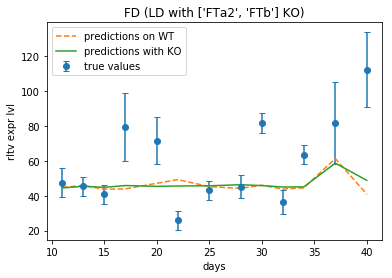

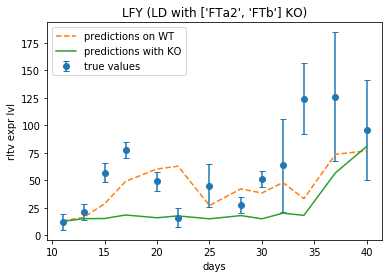

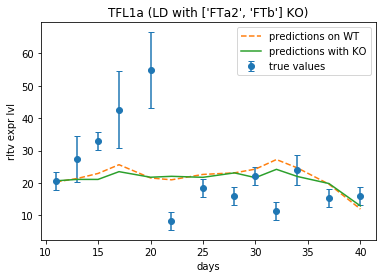

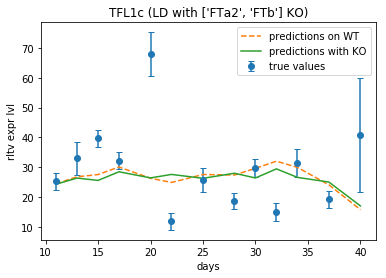

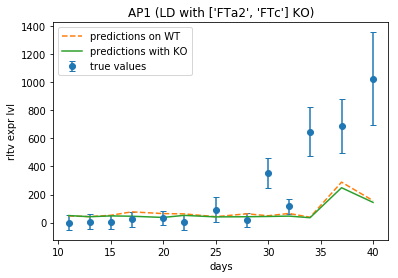

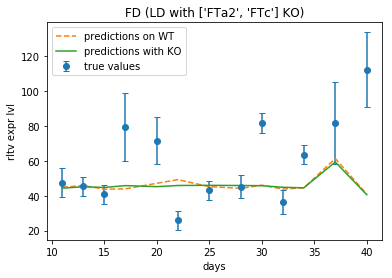

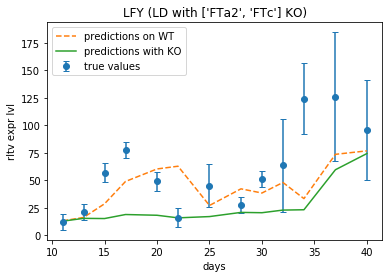

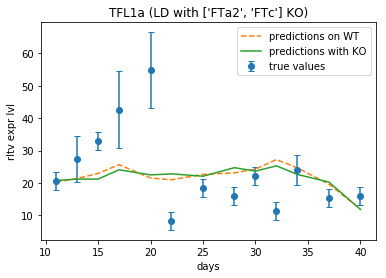

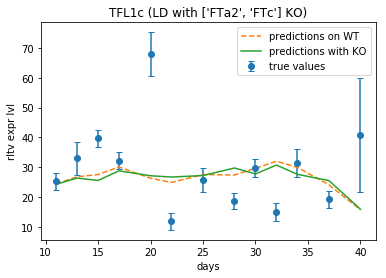

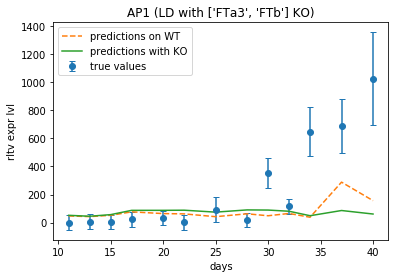

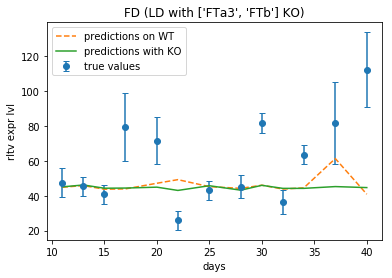

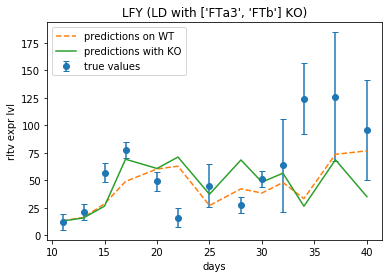

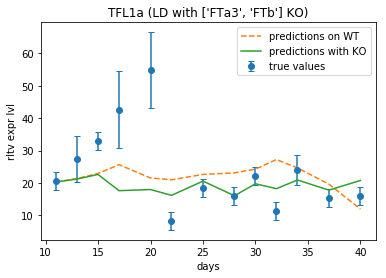

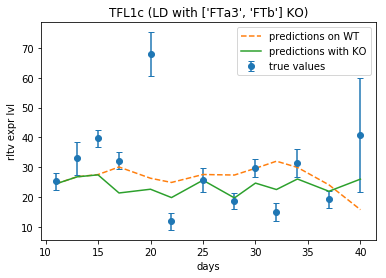

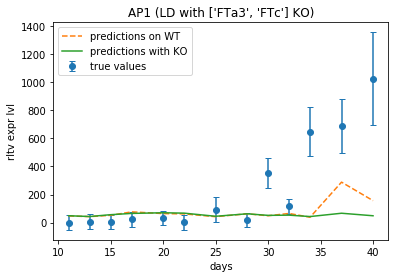

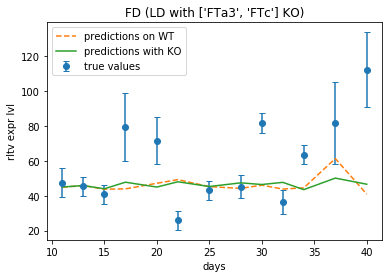

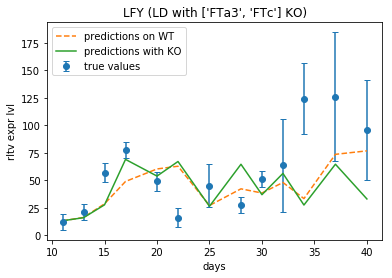

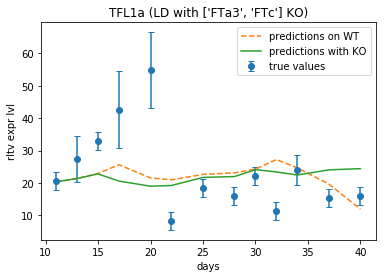

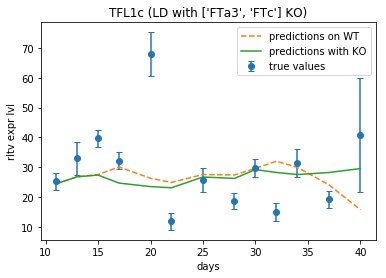

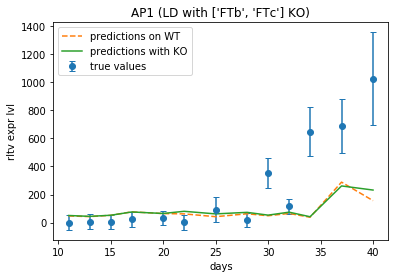

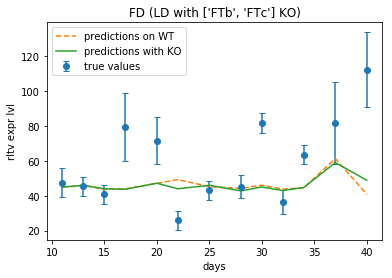

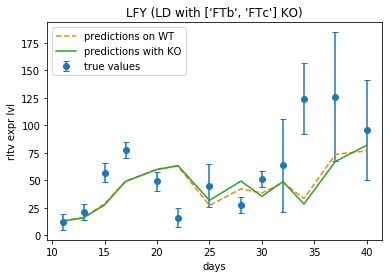

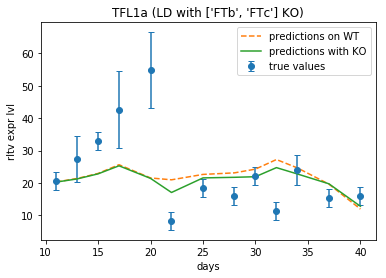

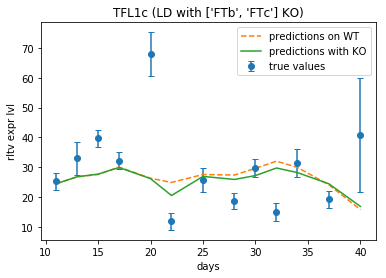

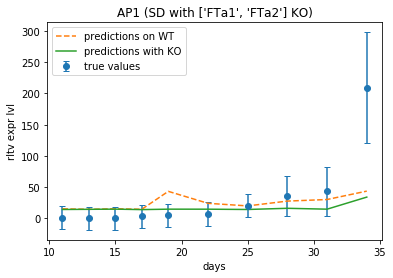

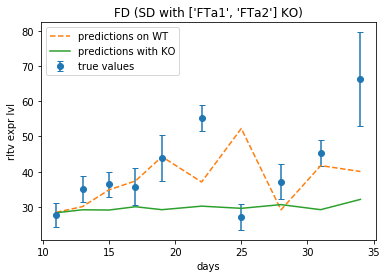

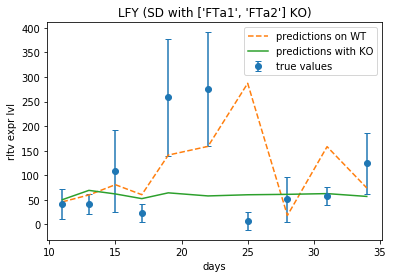

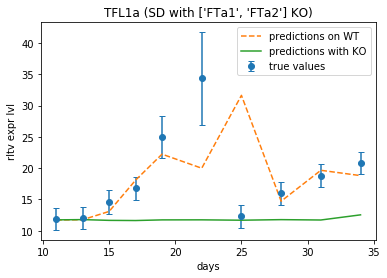

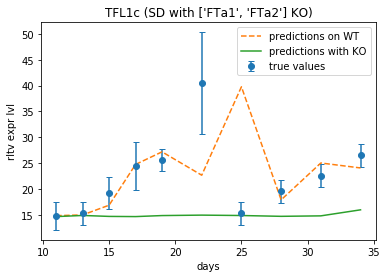

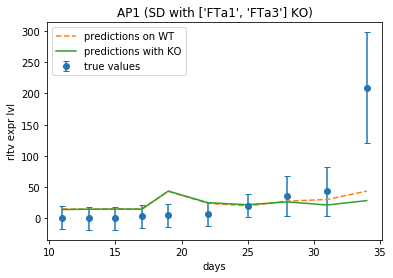

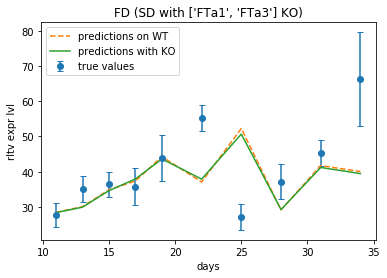

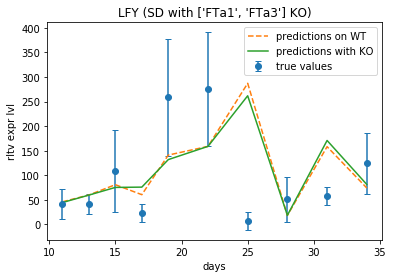

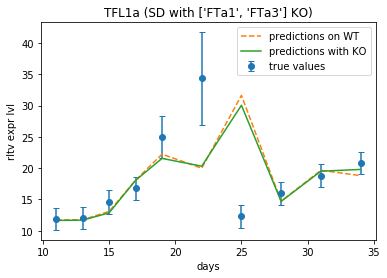

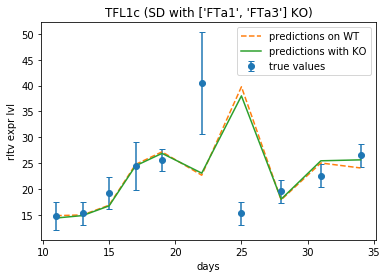

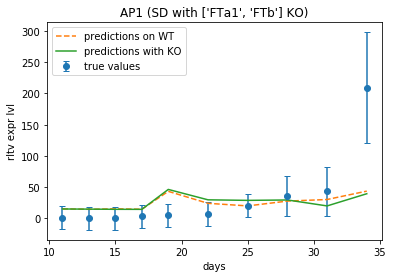

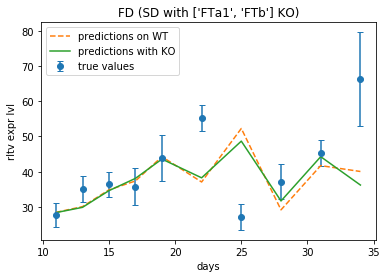

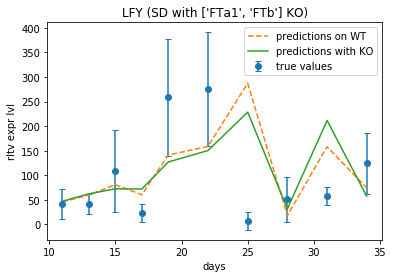

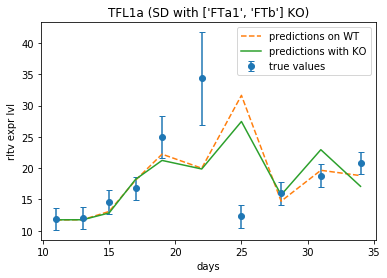

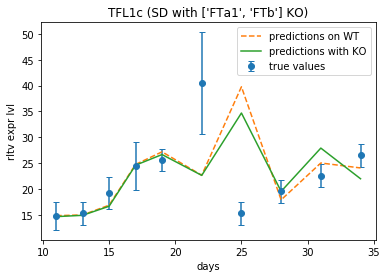

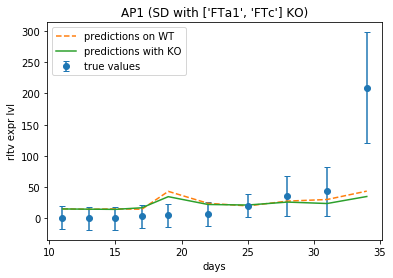

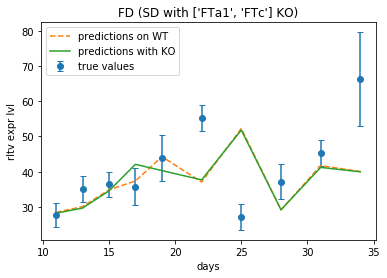

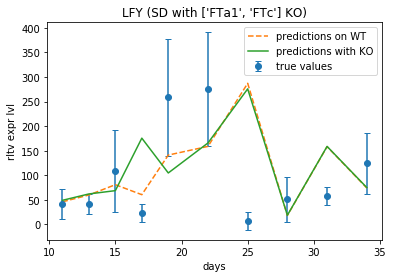

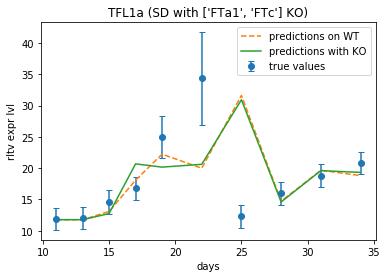

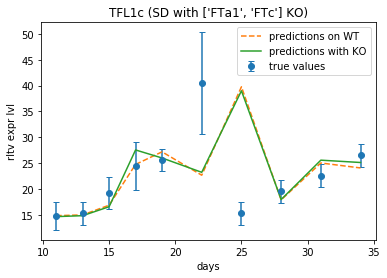

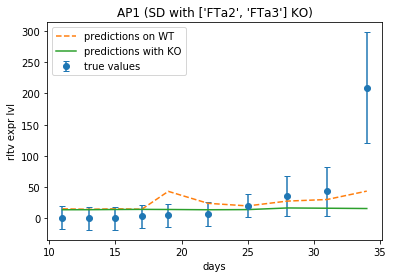

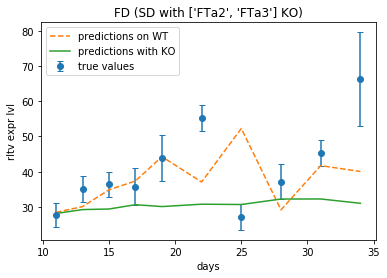

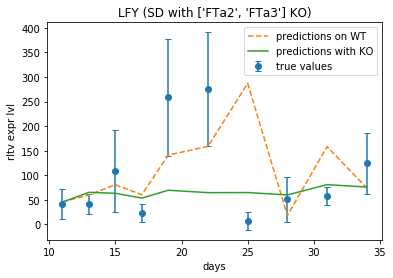

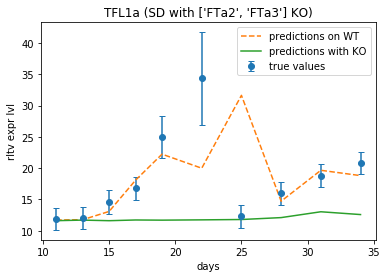

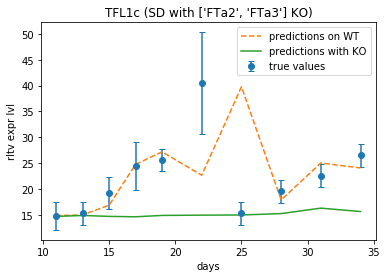

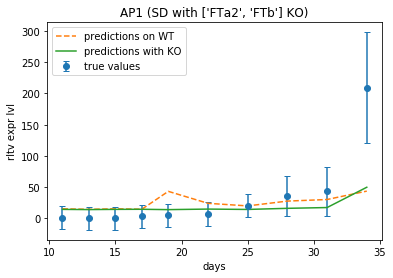

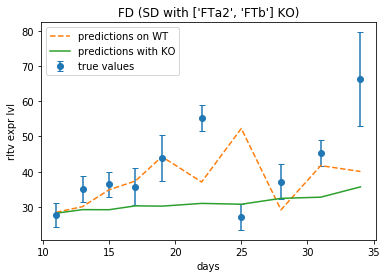

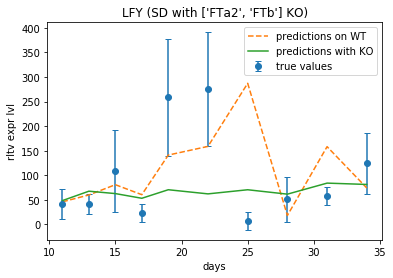

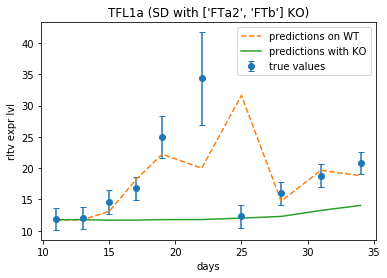

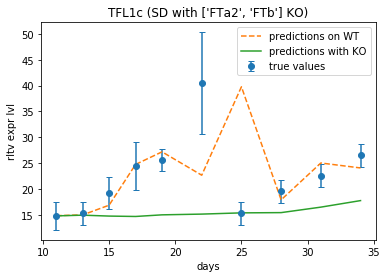

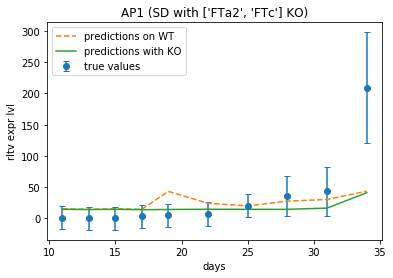

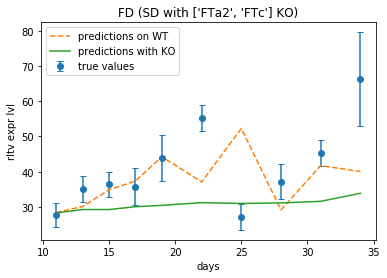

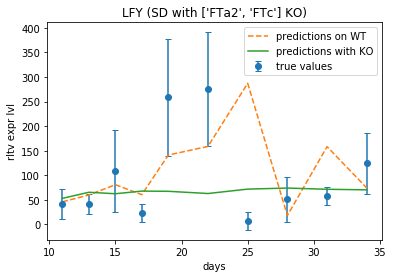

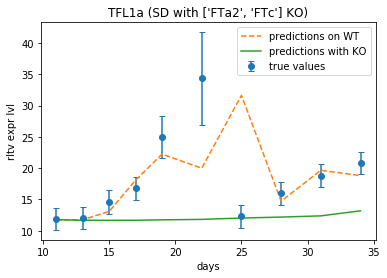

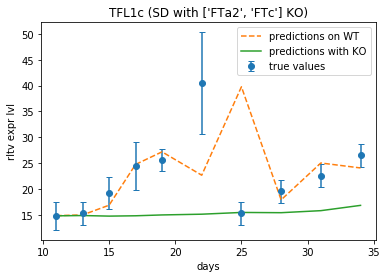

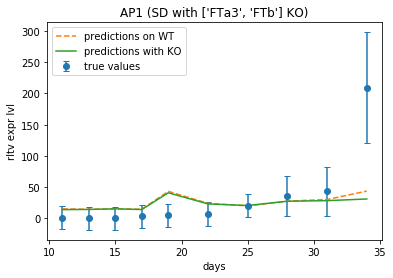

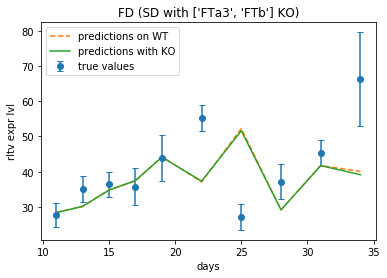

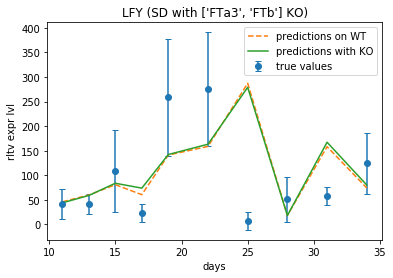

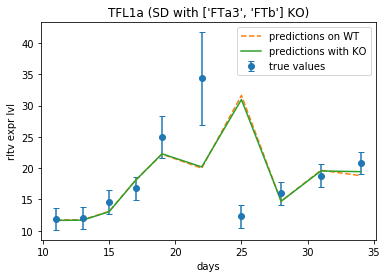

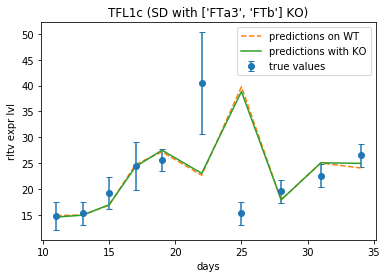

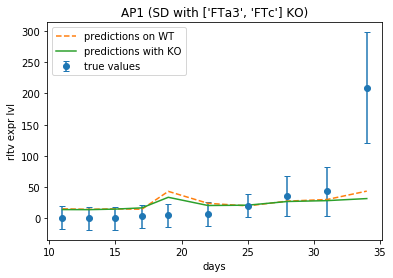

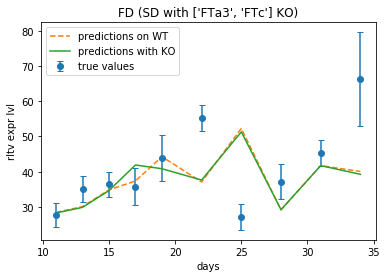

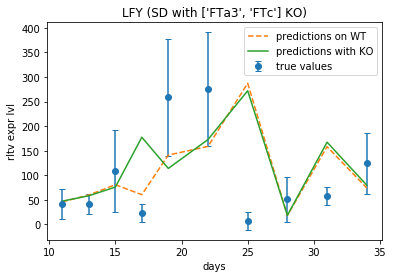

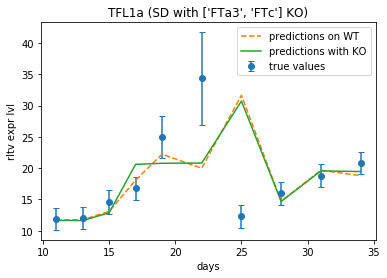

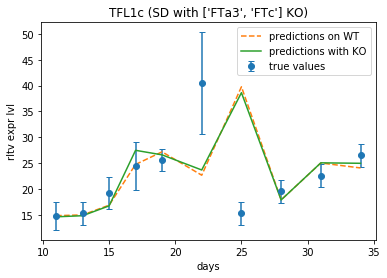

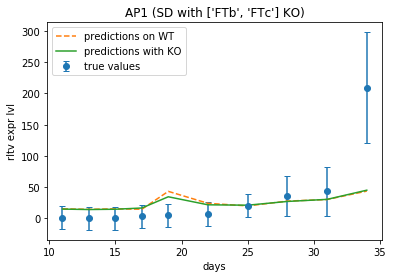

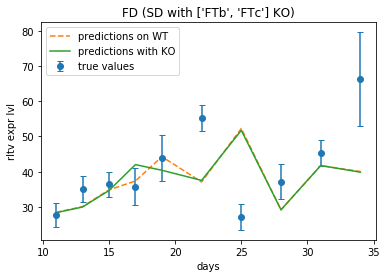

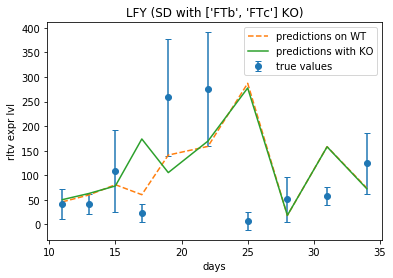

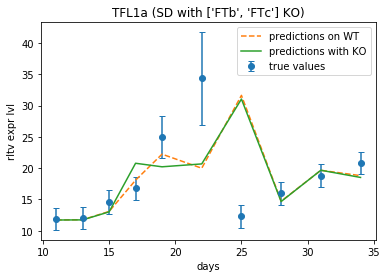

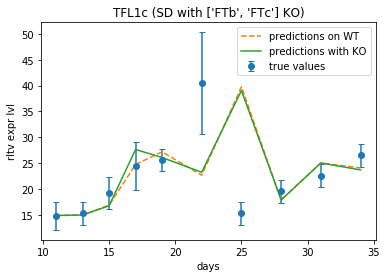

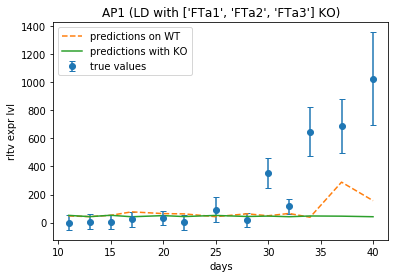

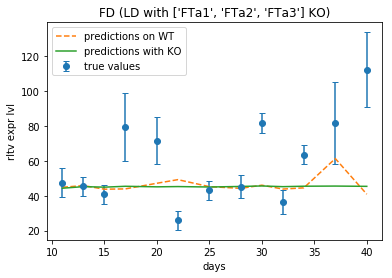

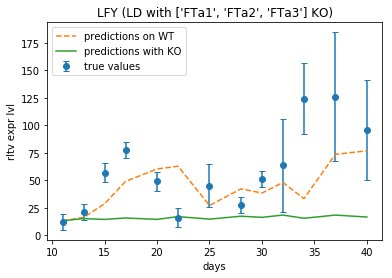

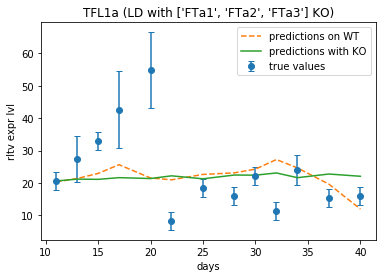

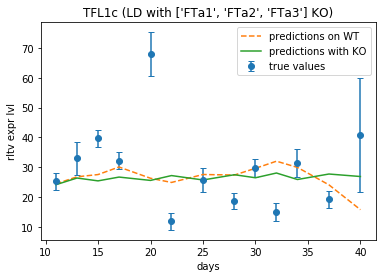

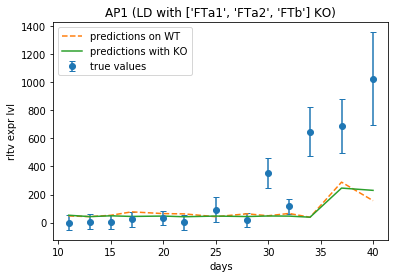

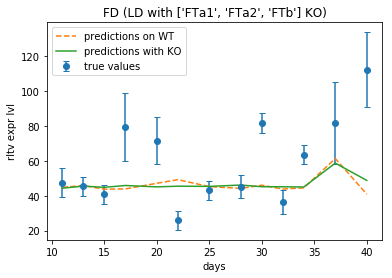

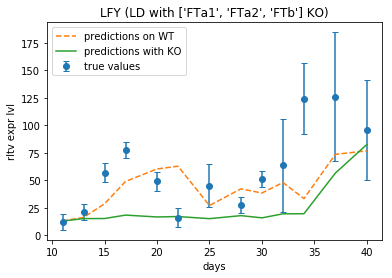

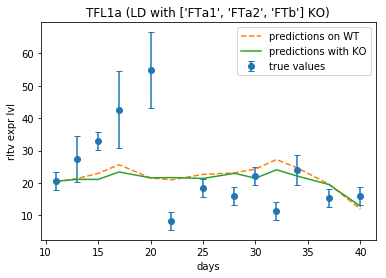

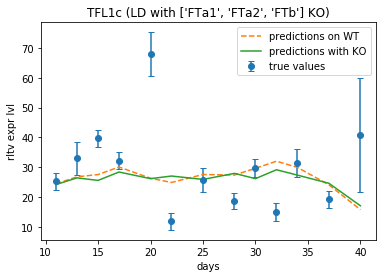

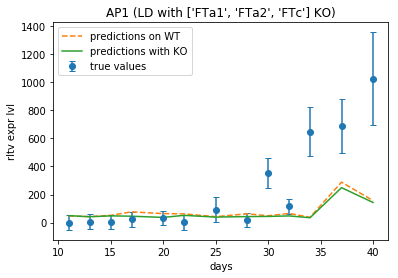

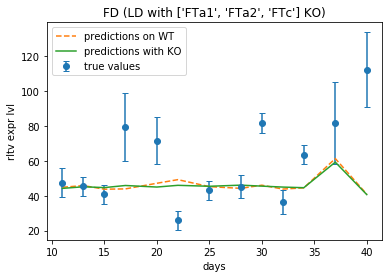

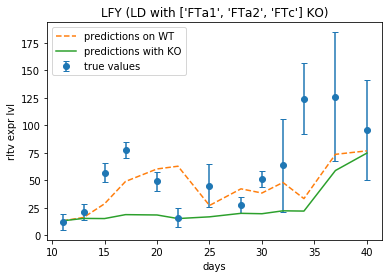

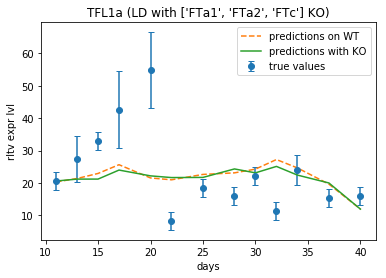

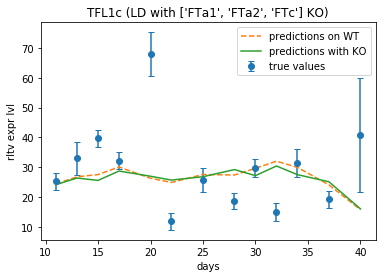

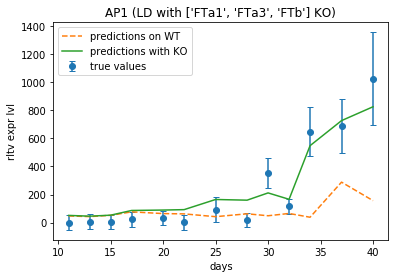

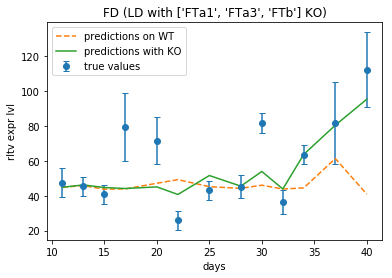

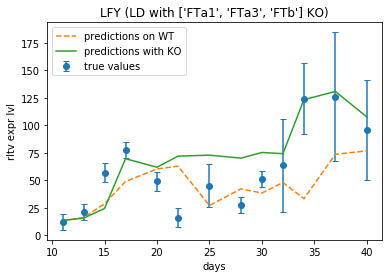

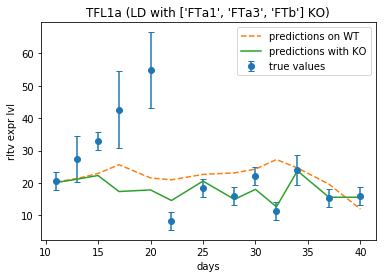

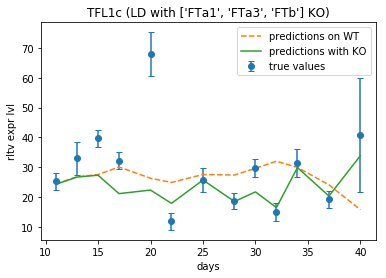

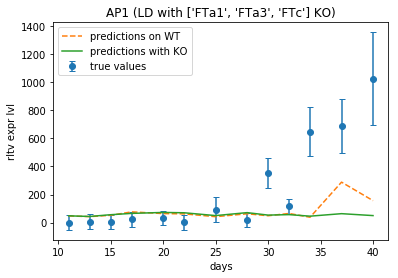

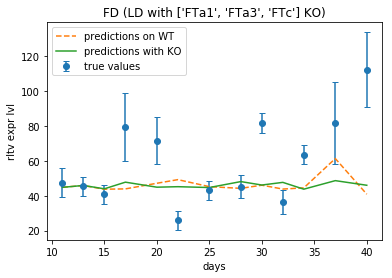

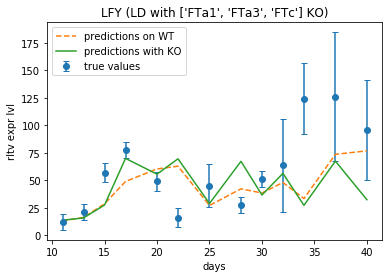

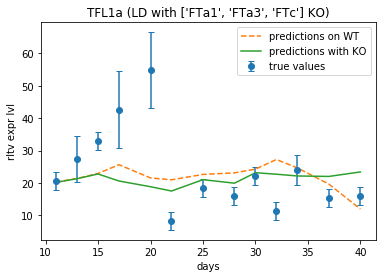

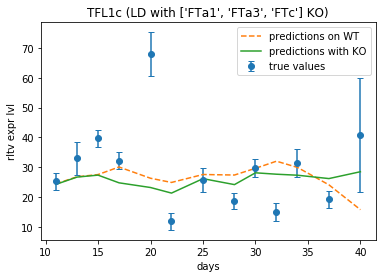

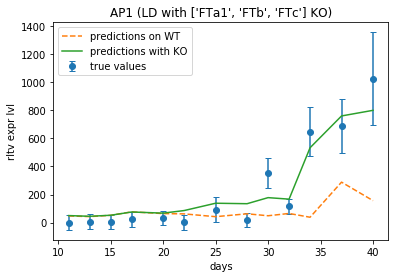

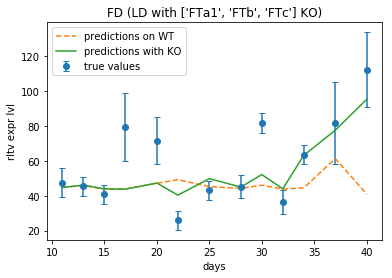

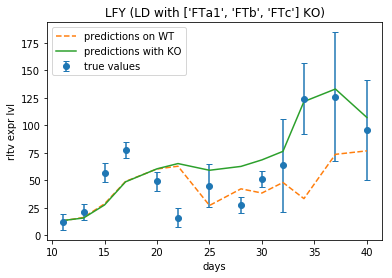

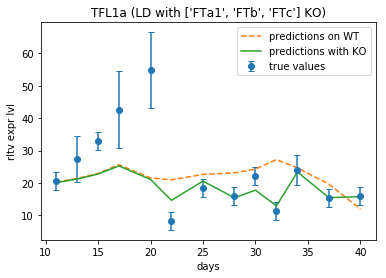

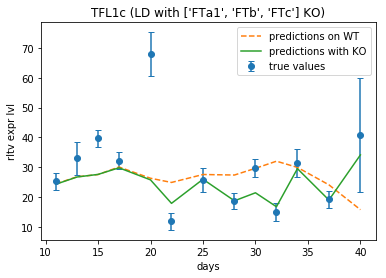

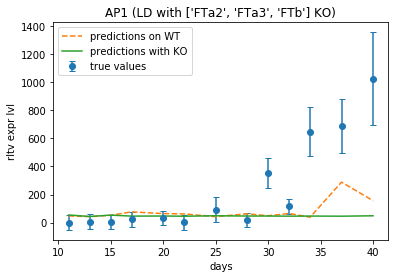

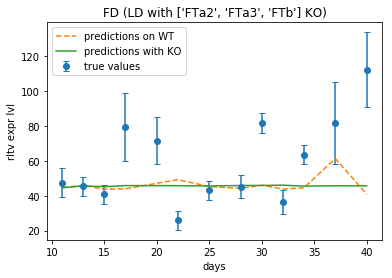

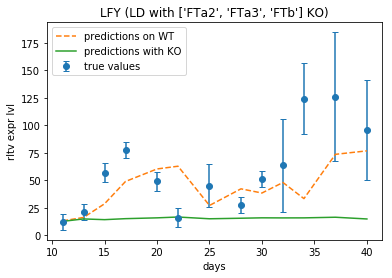

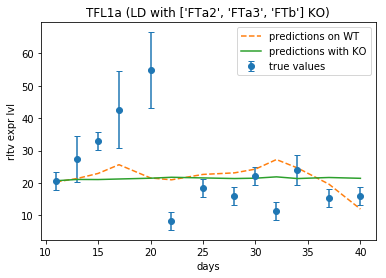

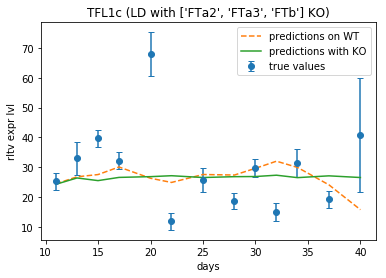

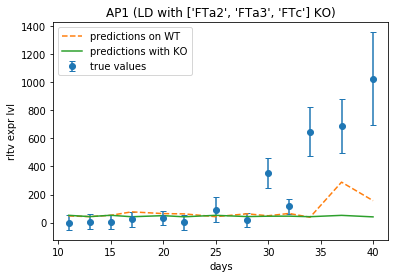

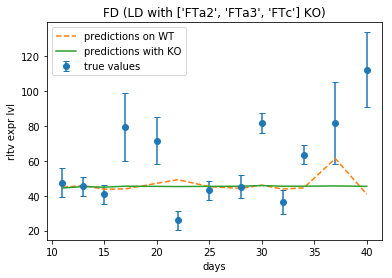

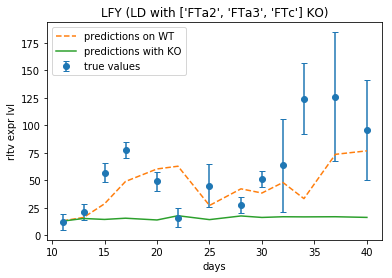

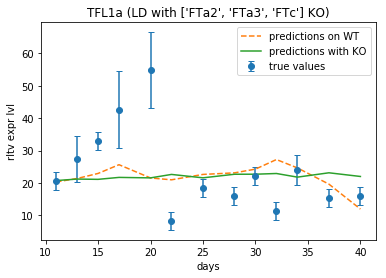

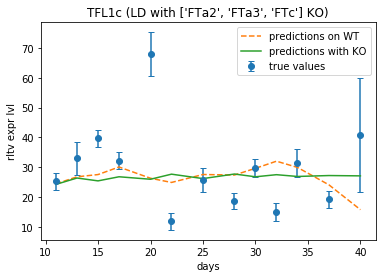

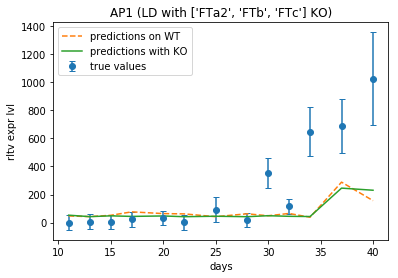

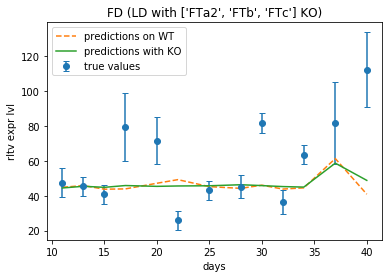

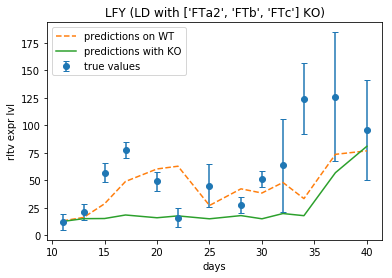

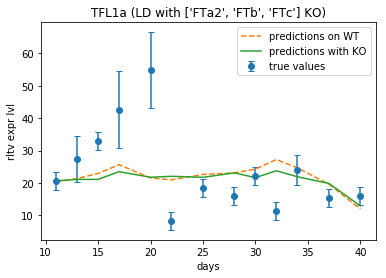

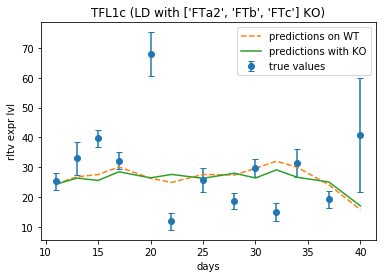

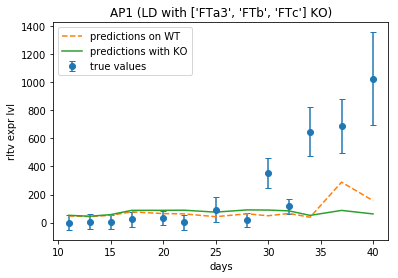

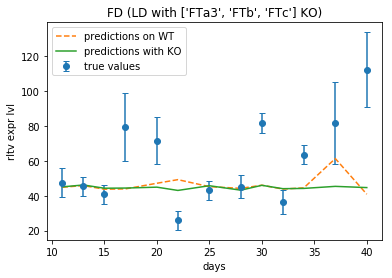

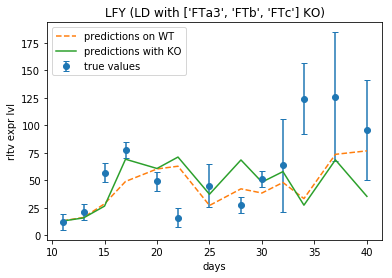

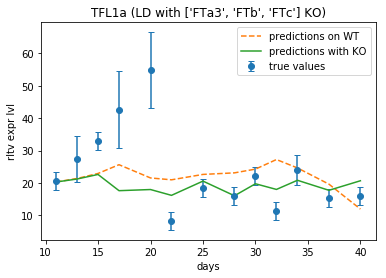

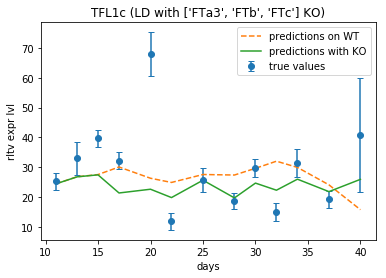

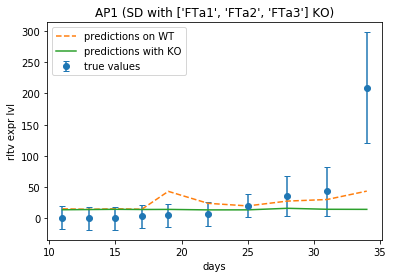

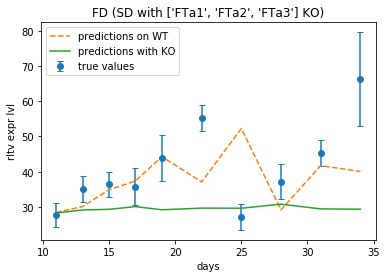

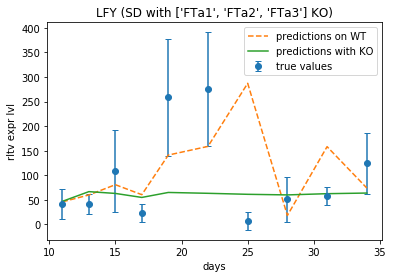

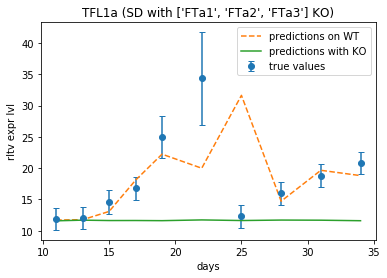

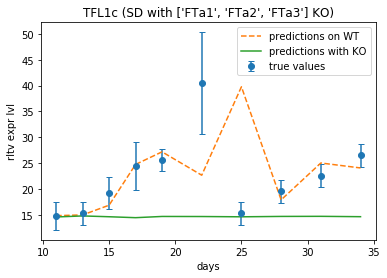

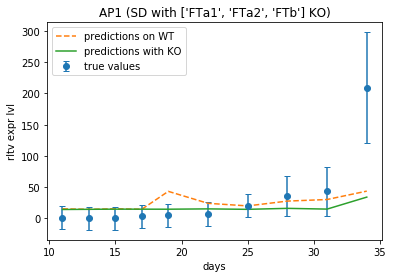

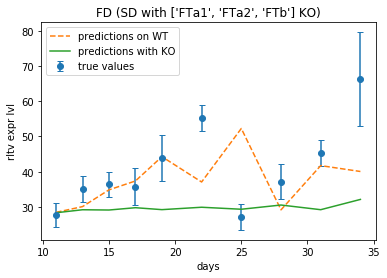

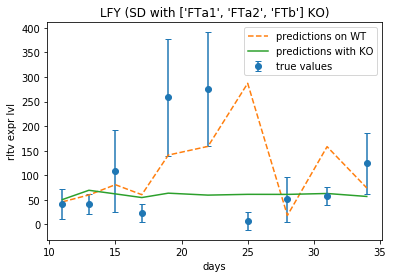

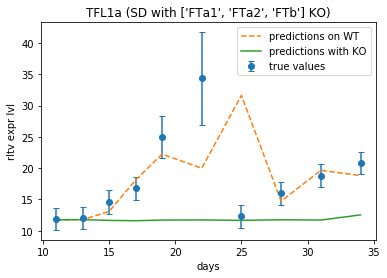

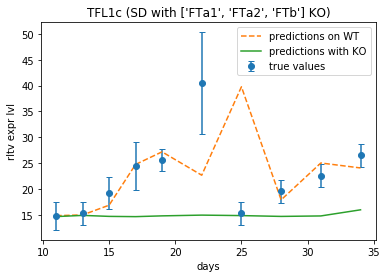

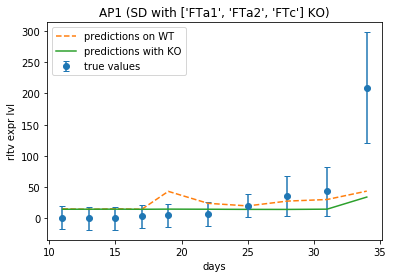

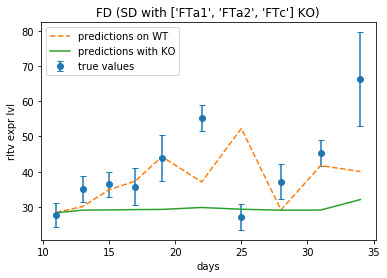

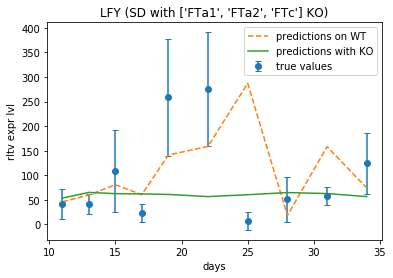

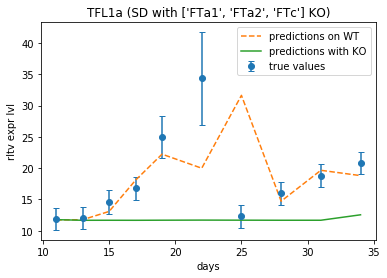

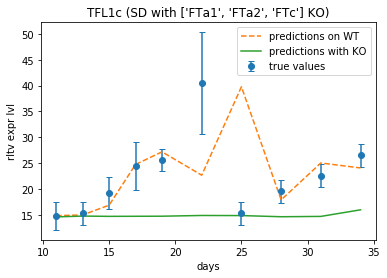

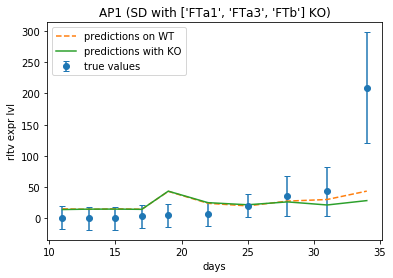

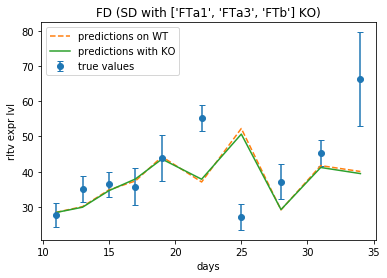

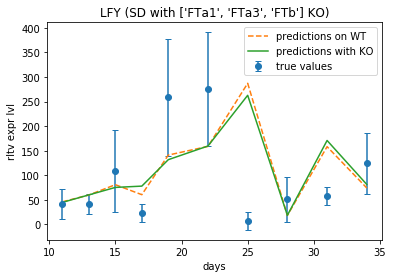

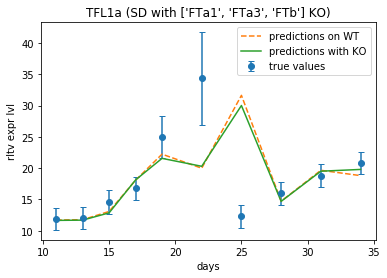

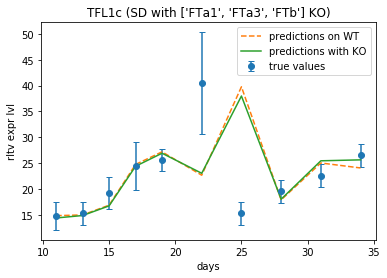

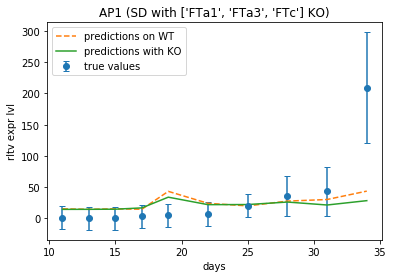

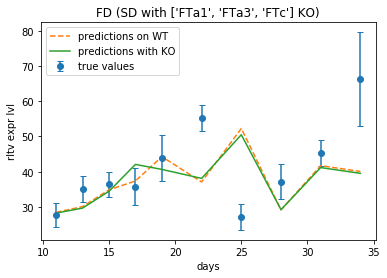

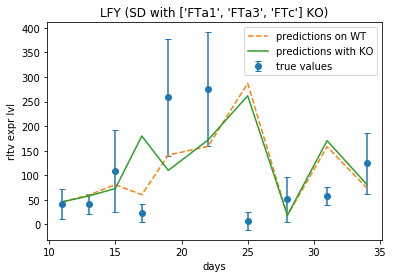

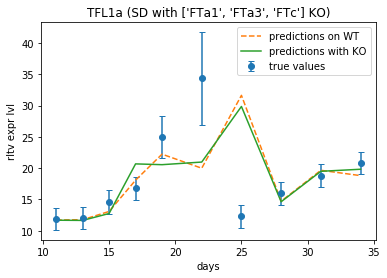

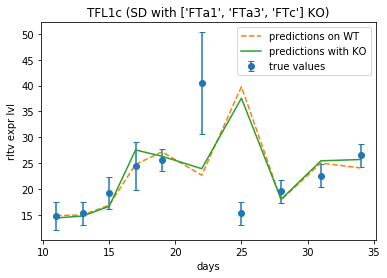

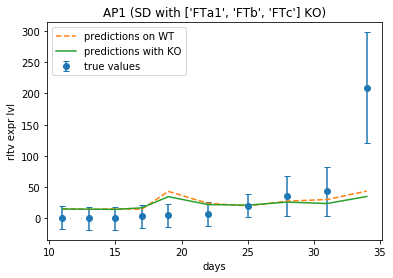

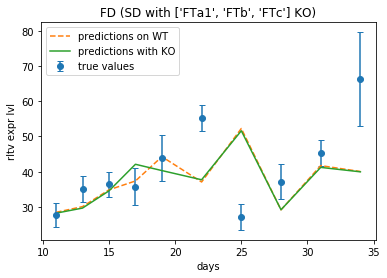

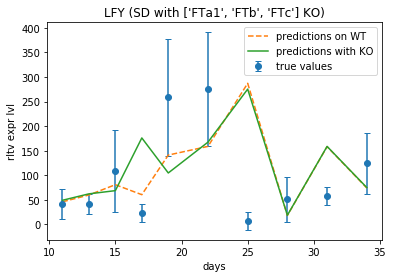

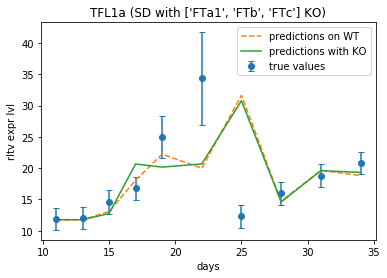

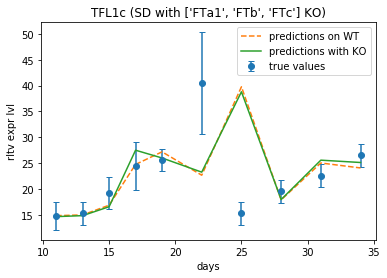

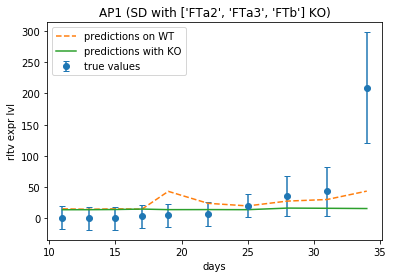

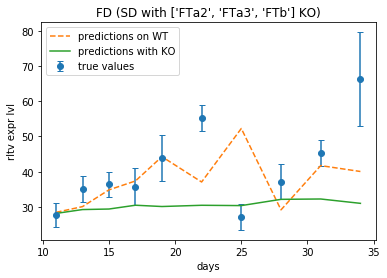

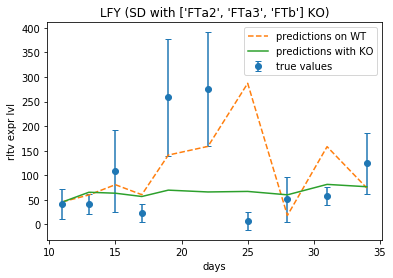

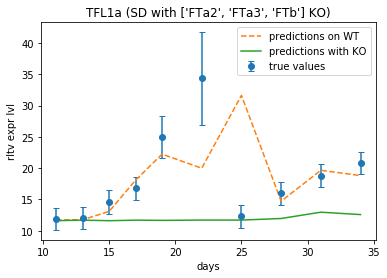

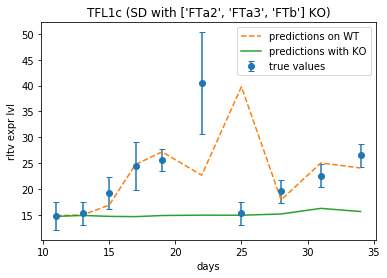

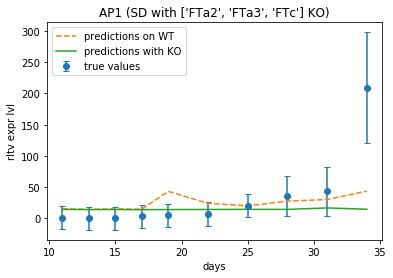

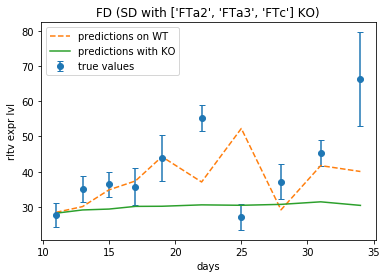

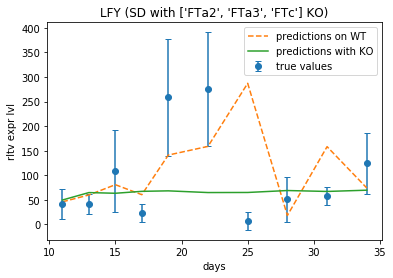

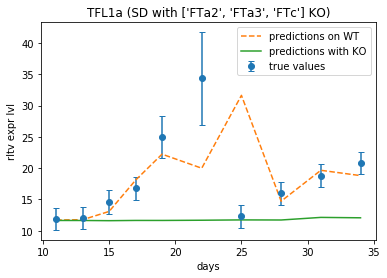

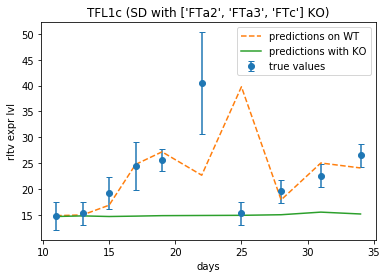

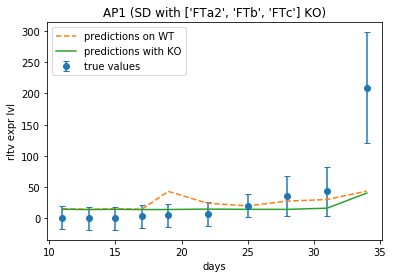

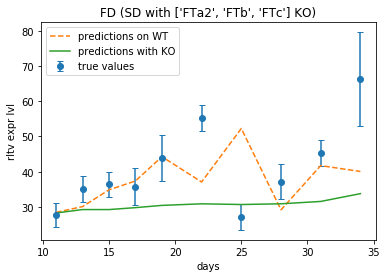

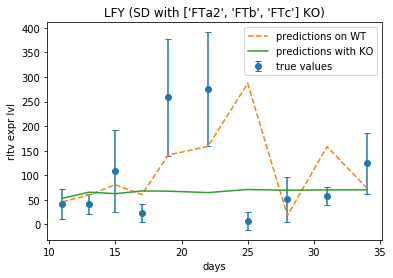

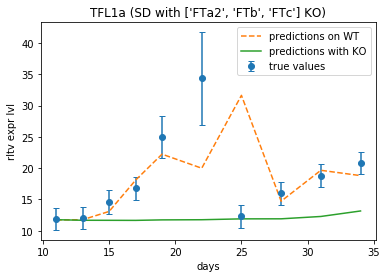

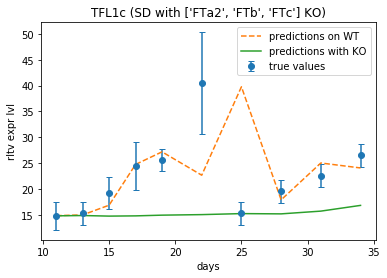

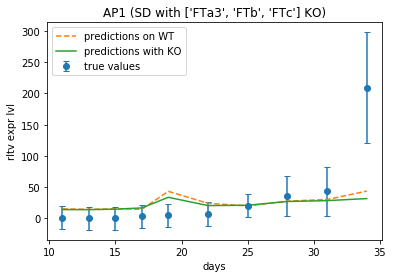

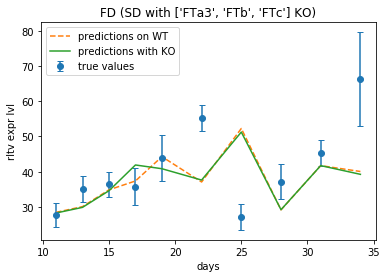

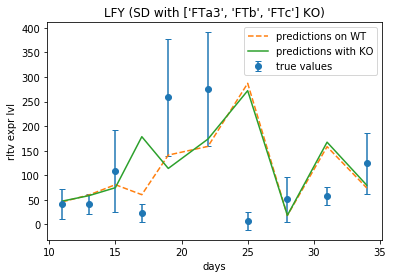

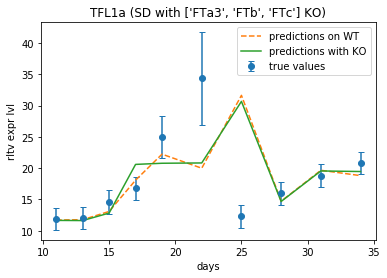

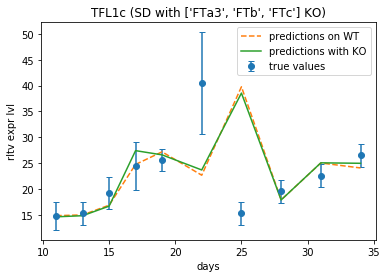

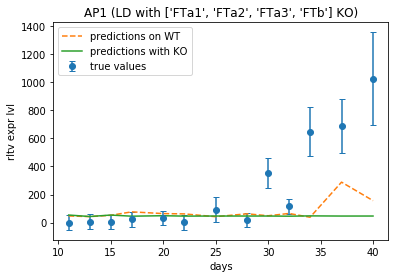

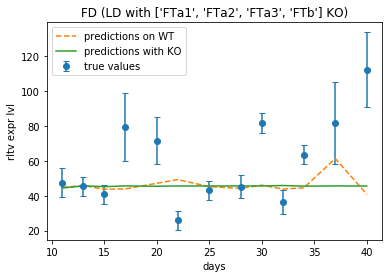

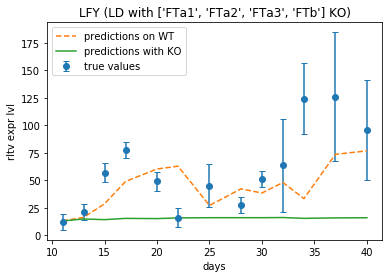

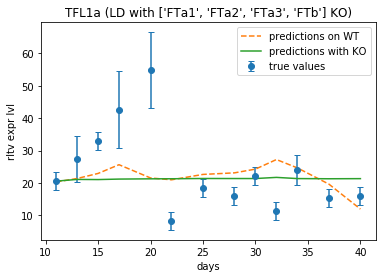

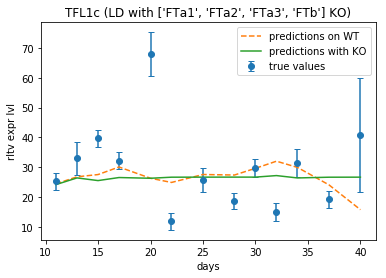

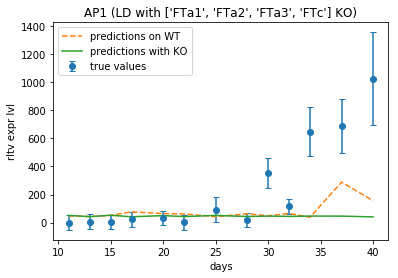

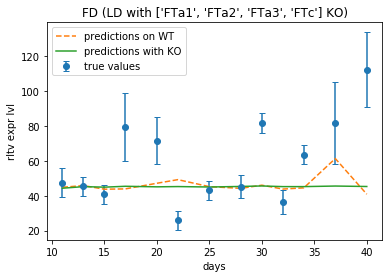

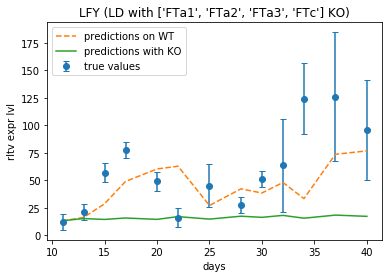

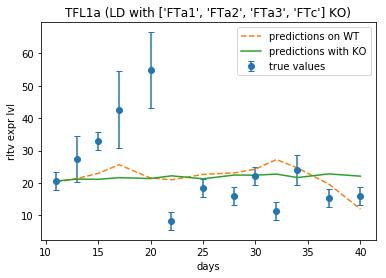

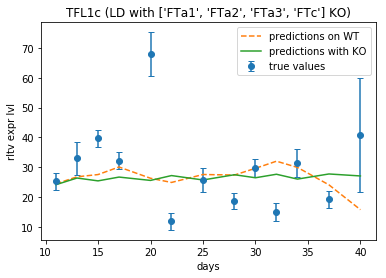

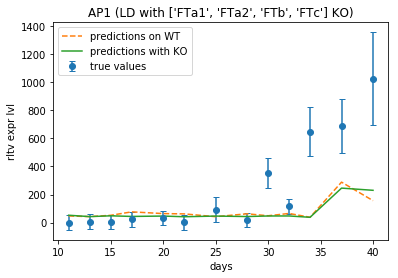

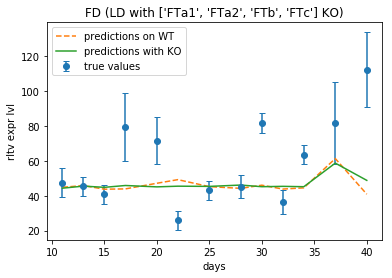

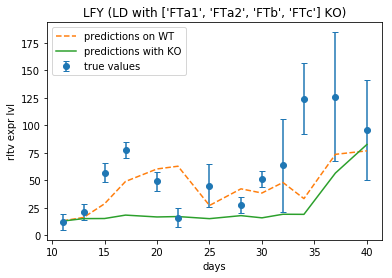

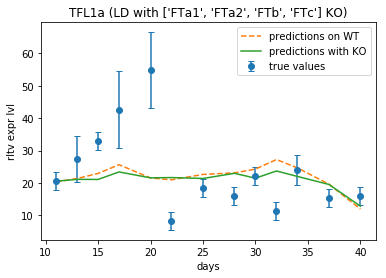

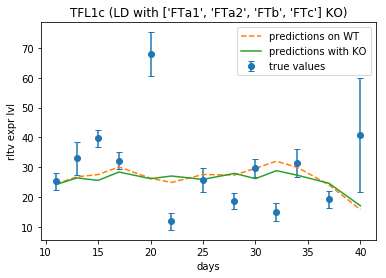

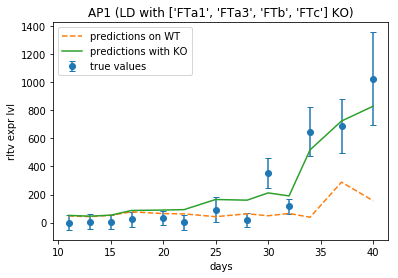

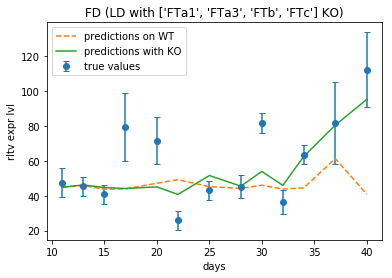

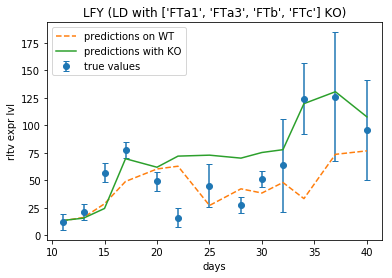

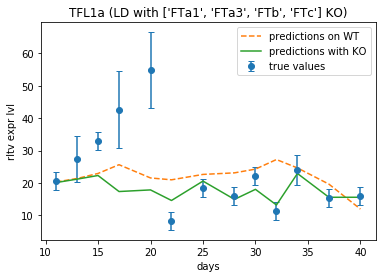

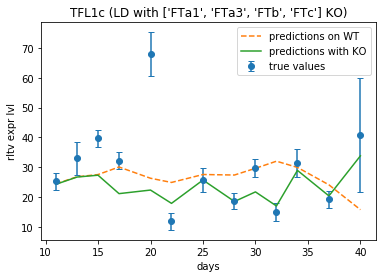

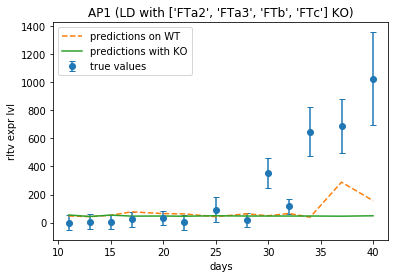

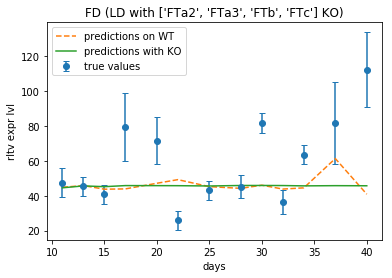

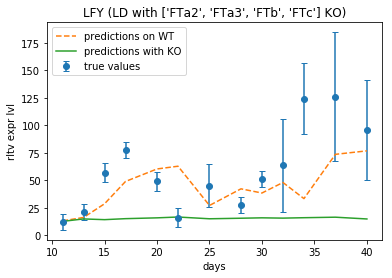

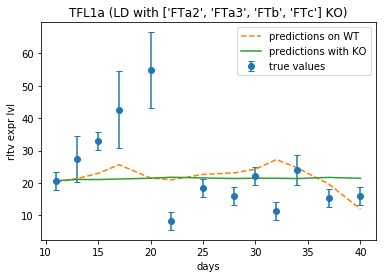

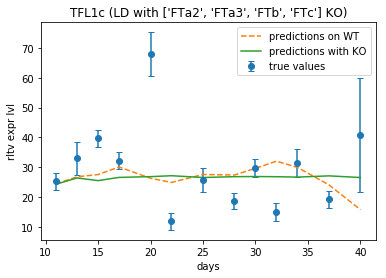

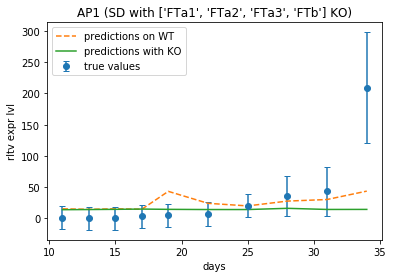

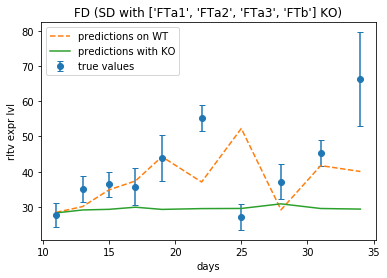

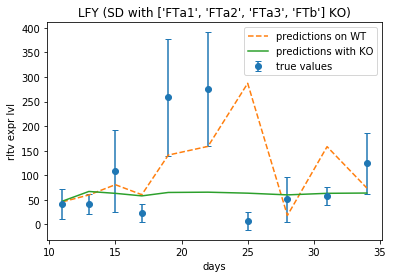

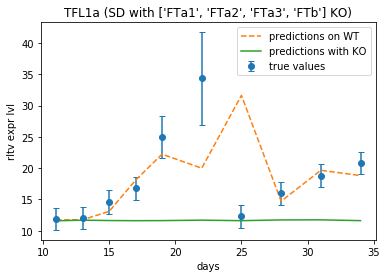

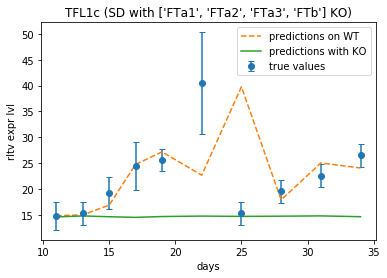

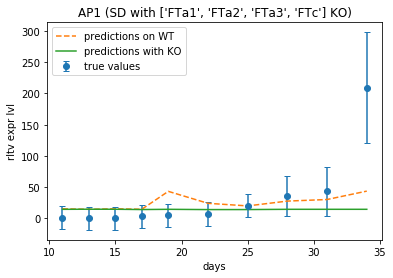

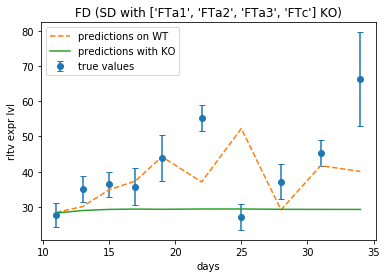

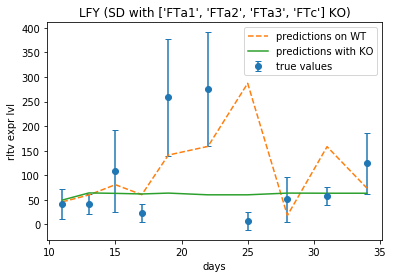

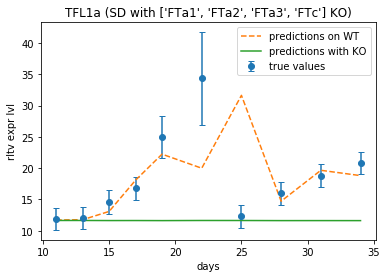

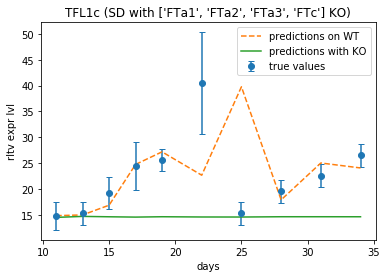

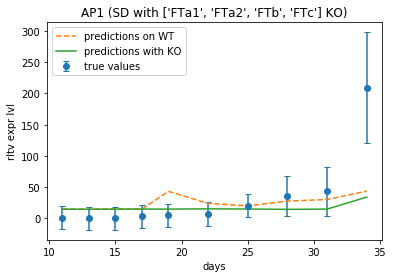

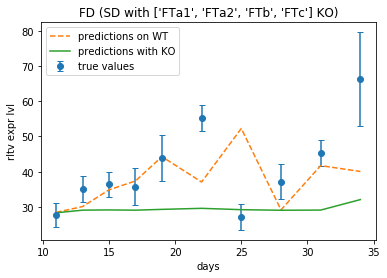

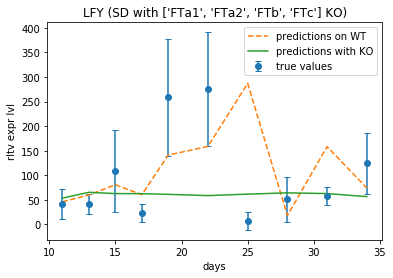

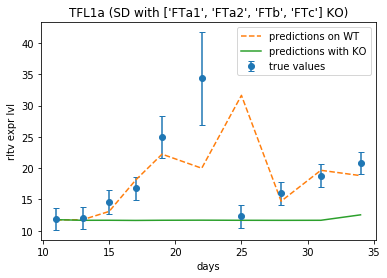

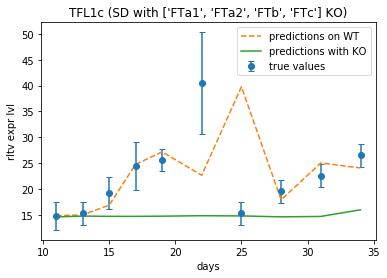

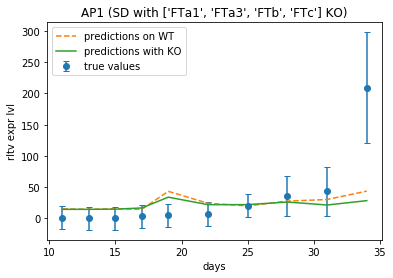

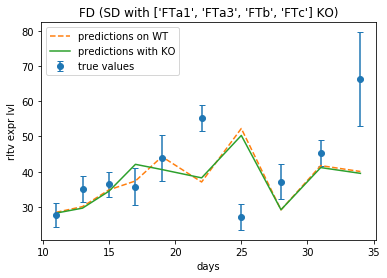

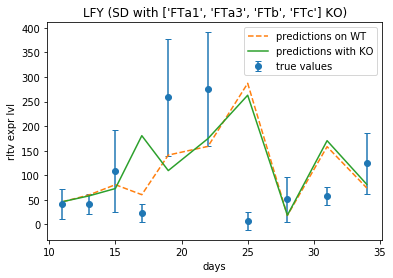

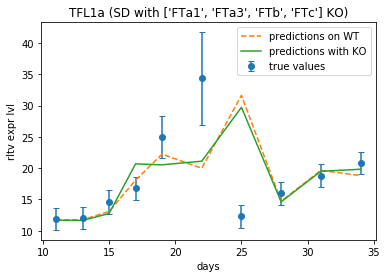

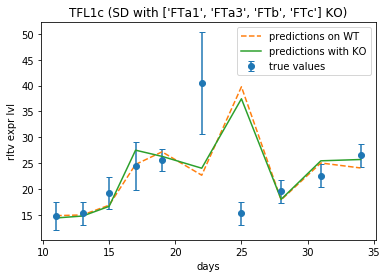

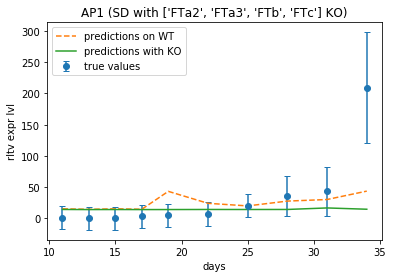

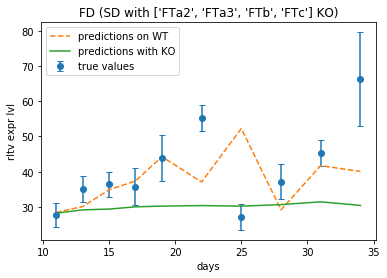

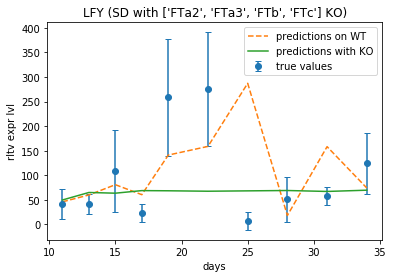

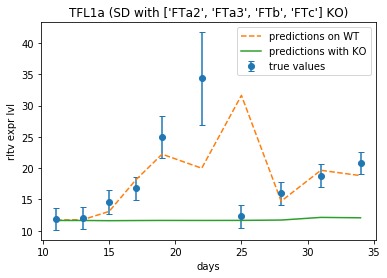

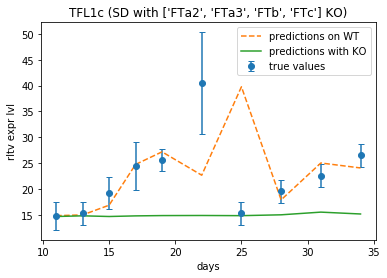

In [85]:
for ko_genes in KO_iterations:
    for cond in conditions:
        for ko_name in ko_genes:

            X_ko = X_real[cond].copy()
            X_ko = X_ko.drop('days', axis = 1)

            pred_ko = [0 for i in range(len(X_ko))]
            
            column = ko_name
            
            if type(ko_name) != type(''):
                ko_name = list(ko_name)
                column = '_'.join(ko_name)
            
            # predictions with KOs:
            for i in range(len(X_ko)):
                X_ko[ko_name] = 0
                pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
                X_ko[targets] = pred_ko[i][0]

            pred_ko = np.array(pred_ko).squeeze()
            
            # plots:
            time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
            
            # AUCs table:
            days_axis = Y_real[cond]['days']
            for i in range(5):
                current_target = targets[i] + '_' + cond
                AUC.loc[current_target, 'WT'] = auc(days_axis, predictions_real[cond].iloc[:, i])
                AUC.loc[current_target, column] = auc(days_axis, pred_ko[:, i])

In [ ]:
X_ko

In [ ]:
AUC.T

# FT dynamics

In [ ]:
FTs

In [ ]:
X_real['LD']

In [ ]:
for f in FTs:
    plt.plot(X_real['LD'].days, X_real['LD'][f], '-o')
    plt.legend(FTs)

In [ ]:
plt.plot(X_real['LD'].days, X_real['LD']['A'], '-o')
plt.plot(X_real['LD'].days, X_real['LD']['FTa2'], '-o')
plt.legend(['LFY', 'FTa2'])

# AUCs

In [ ]:
# AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [118]:
AUC.T

AP1_LD        FD_LD       LFY_LD    TFL1a_LD  \
WT                   2444.459050  1358.554048  1310.186826  646.449344   
AP1                  2487.628988  1461.070736  1419.153202  771.778546   
FD                   2409.680214  1380.523439  1147.676362  607.178355   
LFY                  2325.038158  1356.297903  1077.217377  640.299631   
TFL1a               19949.186847  2241.153454  3041.542759  465.662341   
TFL1c               16466.769483  2262.056351  2739.740109  459.539193   
FTa1                 2477.074611  1346.823441  1311.054496  630.085922   
FTa2                 2049.624174  1351.133302   765.643717  644.742022   
FTa3                 1623.000102  1350.168795  1313.421376  637.531742   
FTb                  2652.889549  1346.751120  1311.227234  616.329595   
FTc                  2443.614431  1358.459684  1310.537974  646.446903   
FTa1_FTa2            2014.877991  1349.323850   733.708898  632.645436   
FTa1_FTa3            1677.654006  1332.576852  1347.019662  614.771942   
FTa1_FTb             7050.114901  1540.437966  2023.770267  550.706536   
FTa1_FTc             2476.375347  1346.853543  1311.291564  630.045957   
FTa2_FTa3            1329.234041  1316.689321   460.501122  640.592993   
FTa2_FTb             2183.329961  1364.835521   698.250655  621.863822   
FTa2_FTc             2013.058154  1351.643664   742.504491  639.983802   
FTa3_FTb             2170.759617  1297.079839  1415.885448  552.044515   
FTa3_FTc             1631.741647  1349.322068  1312.591290  635.669503   
FTb_FTc              2651.796770  1346.600784  1310.811244  615.522588   
FTa1_FTa2_FTa3       1328.153248  1313.585724   463.775791  634.654942   
FTa1_FTa2_FTb        2172.775873  1361.211978   705.256324  617.321713   
FTa1_FTa2_FTc        2015.388146  1349.826323   730.992738  631.331858   
FTa1_FTa3_FTb        7354.264860  1560.818005  2155.274272  521.547272   
FTa1_FTa3_FTc        1690.571154  1336.868249  1345.555686  611.900687   
FTa1_FTb_FTc         7068.176542  1542.507330  2021.141655  550.594446   
FTa2_FTa3_FTb        1363.312872  1325.809448   445.859056  621.510952   
FTa2_FTa3_FTc        1334.295785  1317.176324   457.850315  639.811965   
FTa2_FTb_FTc         2182.770130  1364.977214   697.201988  620.851719   
FTa3_FTb_FTc         2184.976453  1297.033658  1421.329003  551.046523   
FTa1_FTa2_FTa3_FTb   1366.998061  1321.824146   446.797614  617.256973   
FTa1_FTa2_FTa3_FTc   1330.275462  1312.978063   464.247517  634.203799   
FTa1_FTa2_FTb_FTc    2172.982371  1362.150472   702.955299  616.417008   
FTa1_FTa3_FTb_FTc    7325.455332  1562.074379  2153.010707  520.544370   
FTa2_FTa3_FTb_FTc    1366.099775  1325.852886   445.919372  620.736216   

                      TFL1c_LD      AP1_SD        FD_SD       LFY_SD  \
WT                  782.408148  582.047337   884.334897  2780.306214   
AP1                 870.898933  526.490514   878.445426  2820.573218   
FD                  738.719321  424.507467  1002.723742  3726.020855   
LFY                 782.278329  965.979236   925.600370  2399.746067   
TFL1a               784.543881  537.252093   894.086284  2450.873102   
TFL1c               863.886160  642.541076   912.466654  2580.067437   
FTa1                764.739296  599.221288   887.043137  2728.514148   
FTa2                780.873220  395.523428   718.117556  1557.262658   
FTa3                771.968450  548.442363   881.139378  2833.739174   
FTb                 755.029576  586.063399   884.123596  2778.915142   
FTc                 782.344728  560.863803   883.712943  2920.602399   
FTa1_FTa2           770.468265  366.827242   684.938380  1391.917918   
FTa1_FTa3           748.824882  537.809099   878.419013  2748.525345   
FTa1_FTb            700.700282  599.929998   885.353435  2730.566517   
FTa1_FTc            764.668972  525.699871   881.138140  2893.597535   
FTa2_FTa3           776.056082  338.818959   705.947099  1510.263011   
FTa2_FTb            762.883548  396.591067   715.258326  1550.1

In [124]:
AUC_norm = AUC.T / AUC.WT

In [12]:
for col in AUC_norm.columns:
    AUC_norm.loc[col[:-3], col] = 1.

## Heatmap

In [23]:
def my_heatmap(data, figsize = (15, 5)):
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(data, robust = True, center=1, cmap = 'RdBu_r')
    plt.xlabel('KO genes')
    plt.ylabel('AUC relative to WT AUC')
    
    fig_path = results_path + 'dynamic/'

    if not os.path.exists(fig_path):
        os.makedirs(fig_path)

    plt.savefig(fig_path + 'Heatmap.svg', format='svg', bbox_inches='tight')

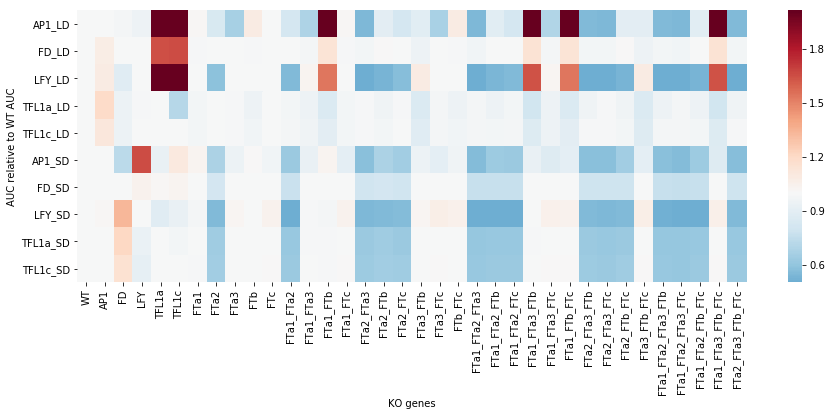

In [24]:
my_heatmap(AUC_norm.T)

## Barplots

In [5]:
def AUC_barplots(dataframe, format='svg'):
    for index in dataframe.index:
        df = dataframe.drop([index[:-3], 'WT'], axis=1)
        df.loc[index] = df.loc[index] / dataframe.loc[index, 'WT']
        col = df.columns
        
        plt.figure(figsize=(20,10))

        myplot = sns.barplot(y = index, x = col, data = df.T)
        plt.xticks(rotation=60)
        plt.xlabel('KO genes')
        plt.ylabel('KO/WT transcription level')
        plt.title(index.replace('_', ' '))
        myplot.axes.axhline(1, dashes=(5, 1))
        
        fig_path = results_path + 'dynamic/barplots/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{index}.{format}', bbox_inches='tight', format=format, dpi=300)
        plt.show()

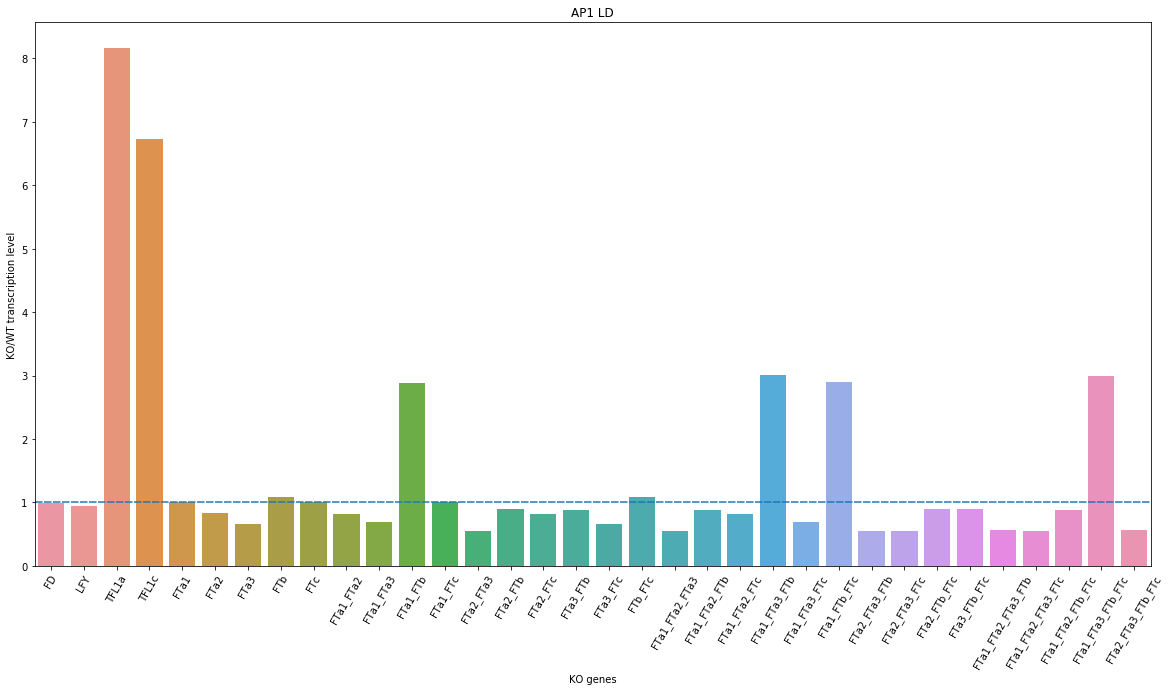

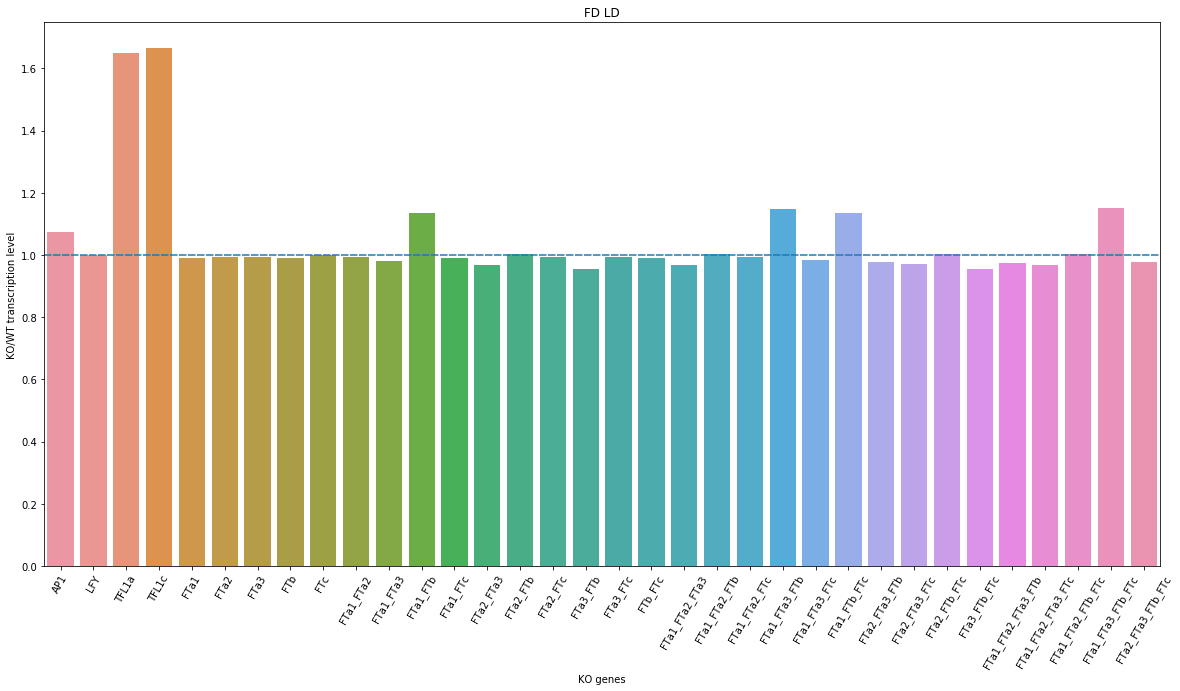

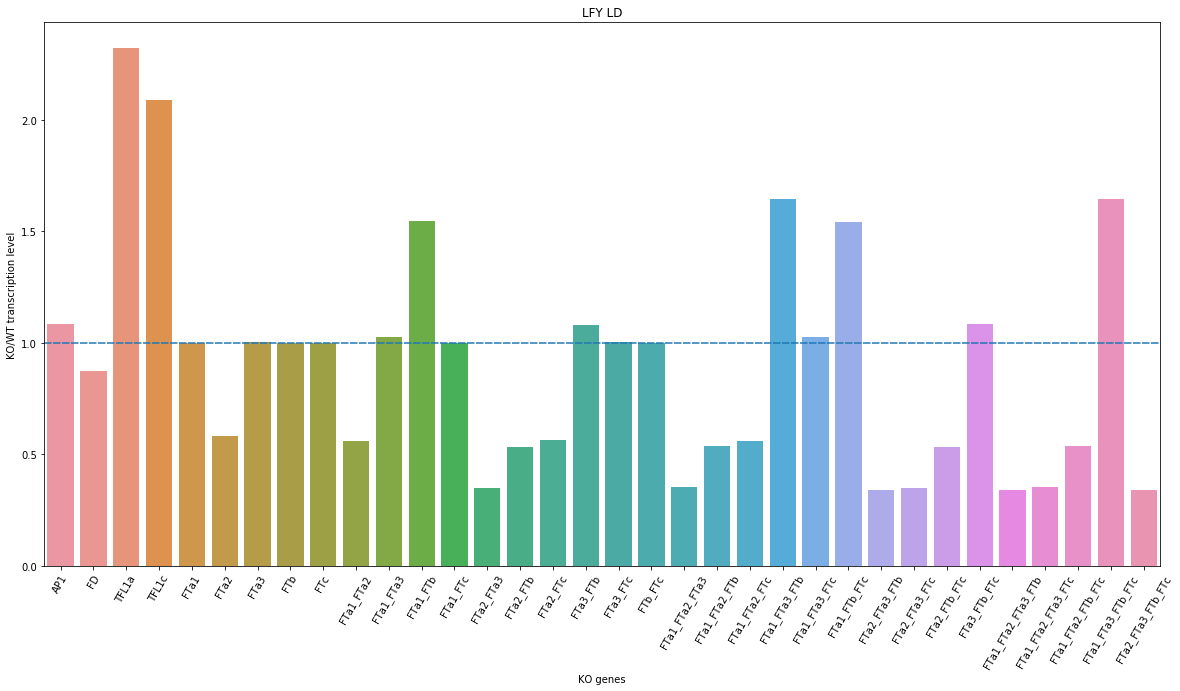

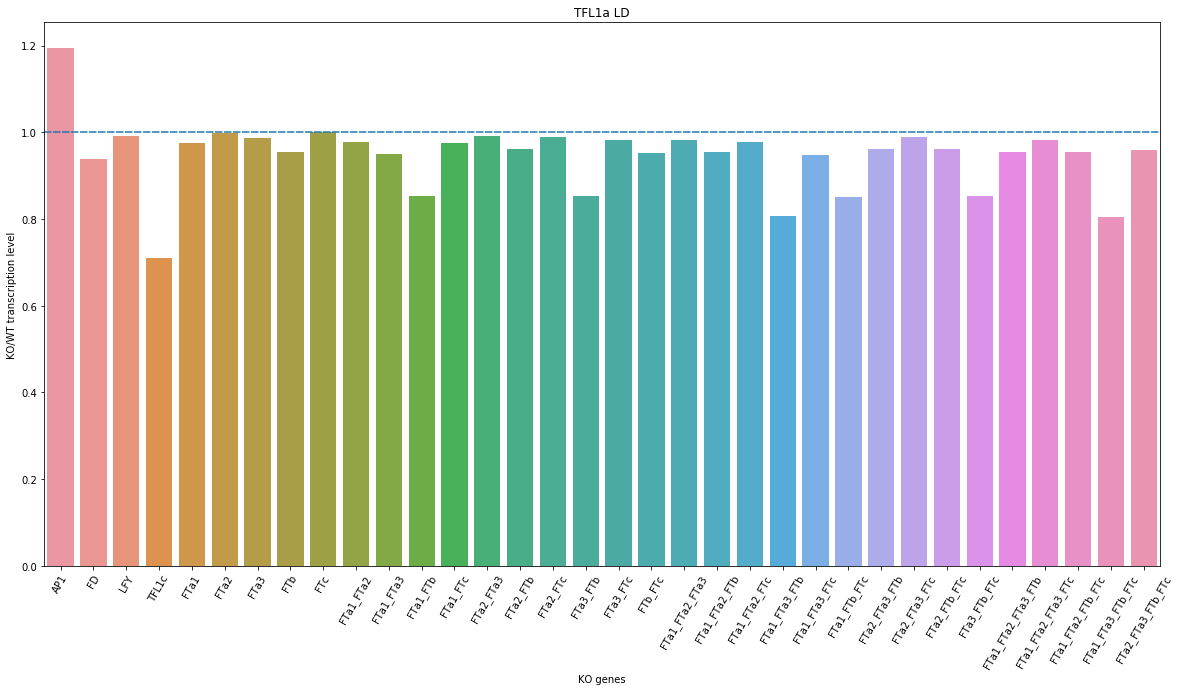

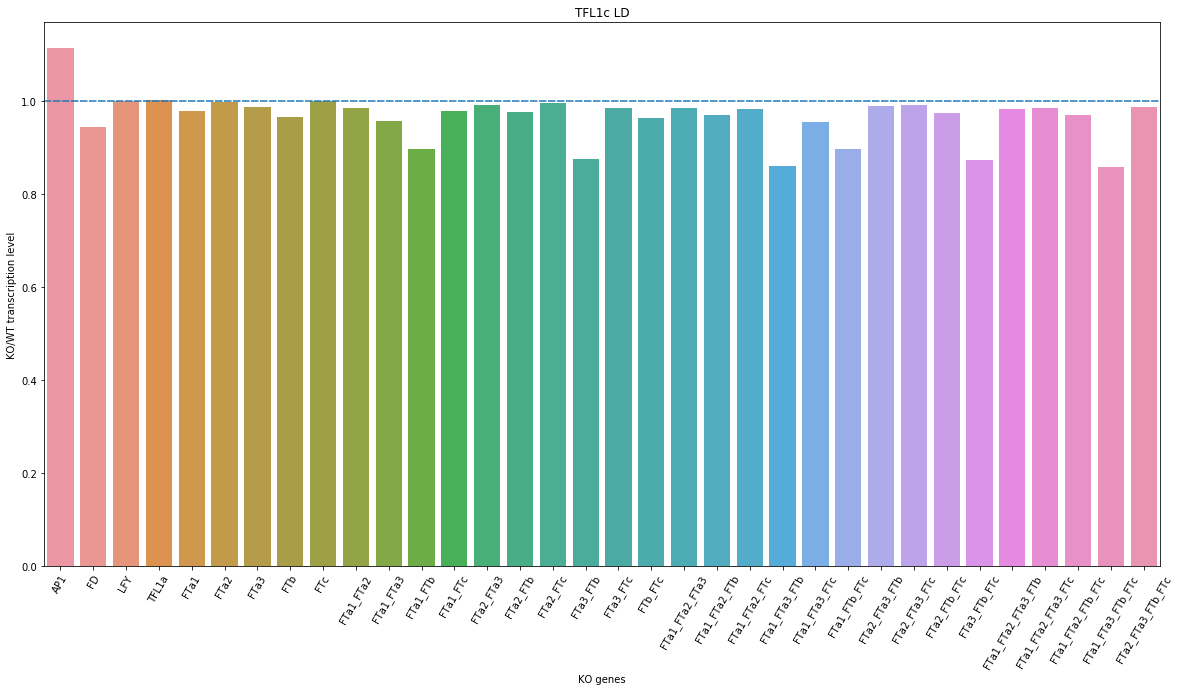

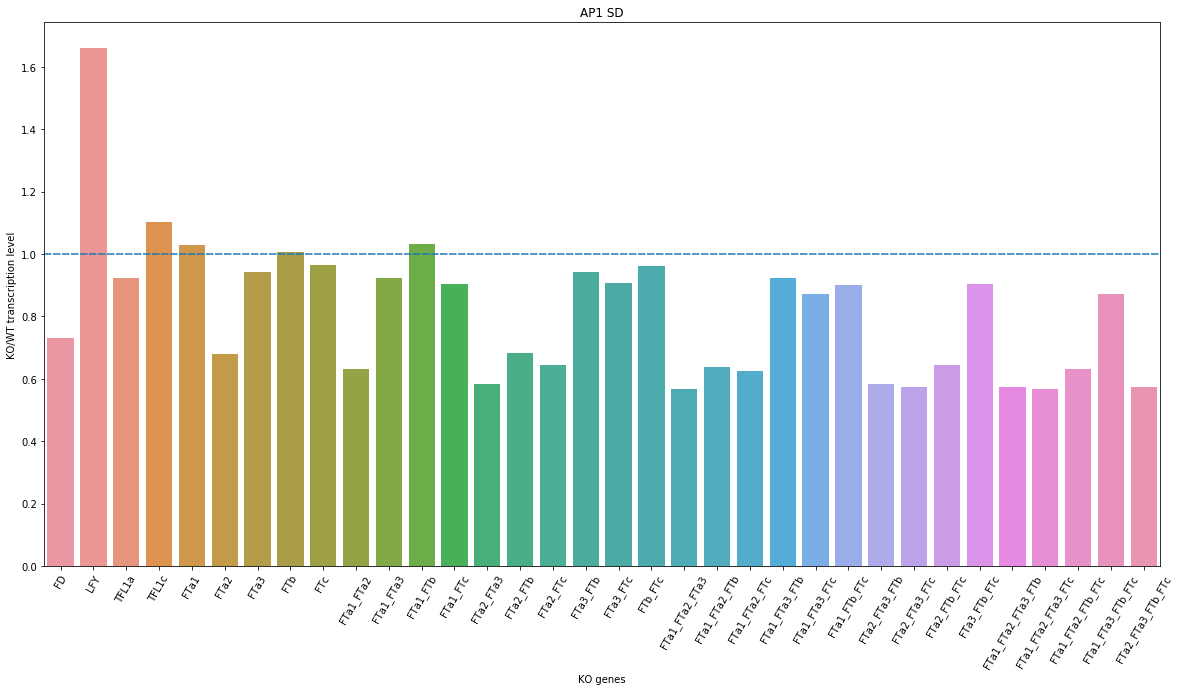

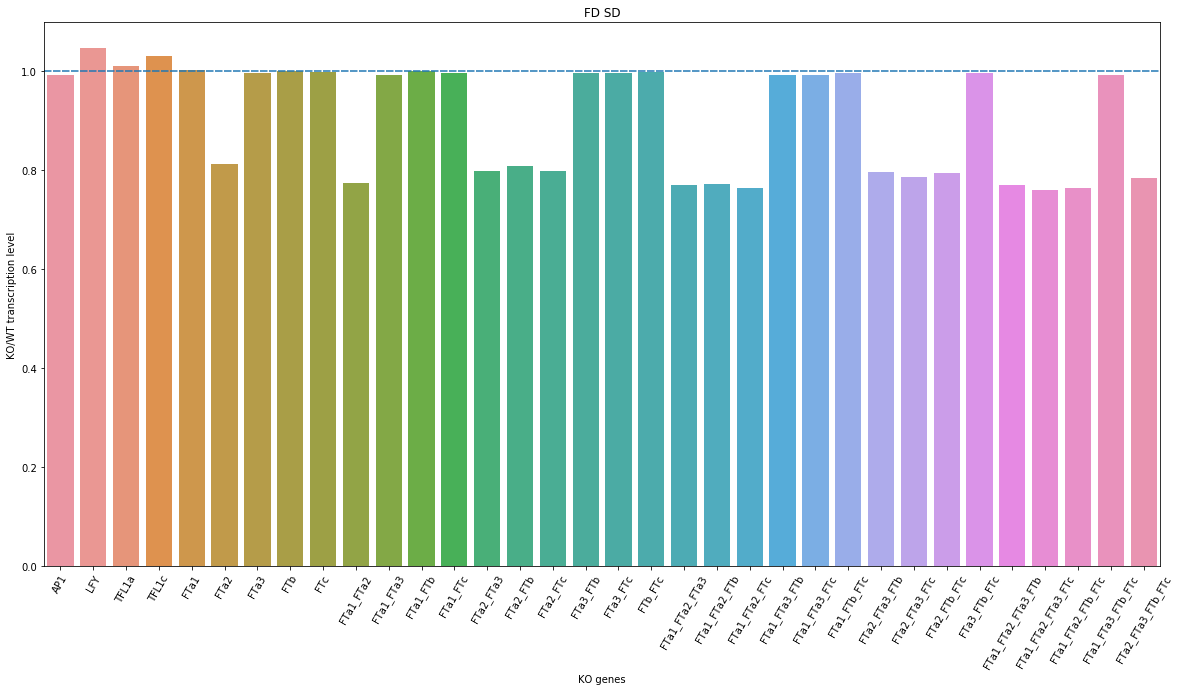

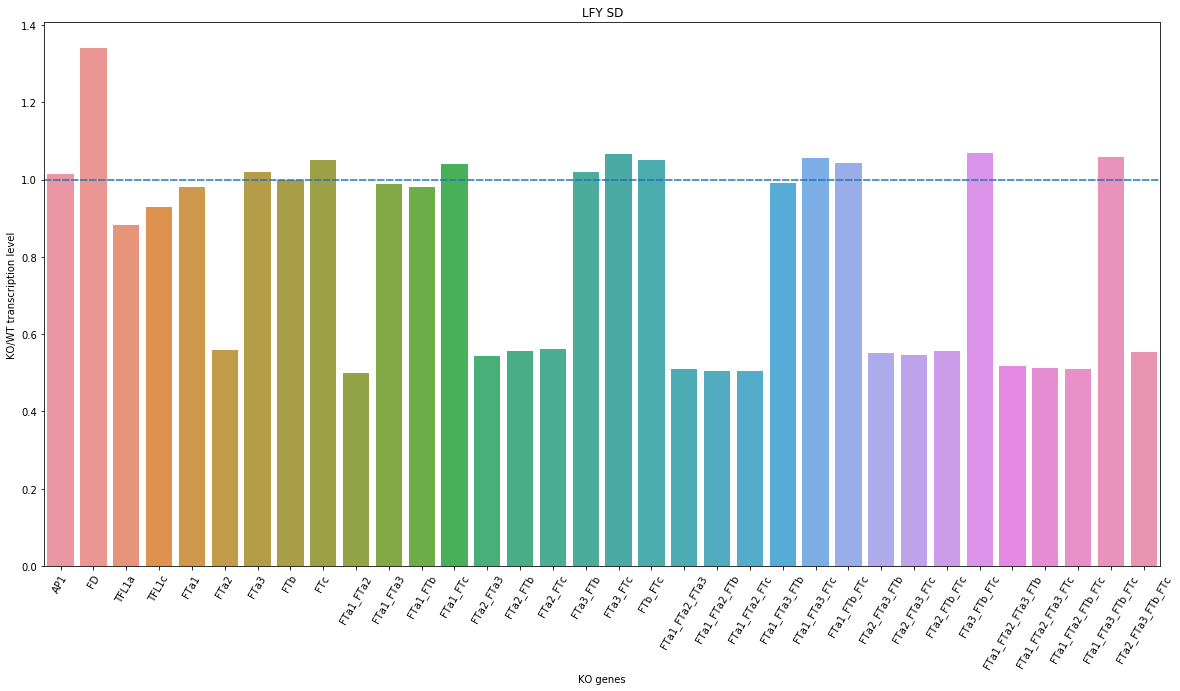

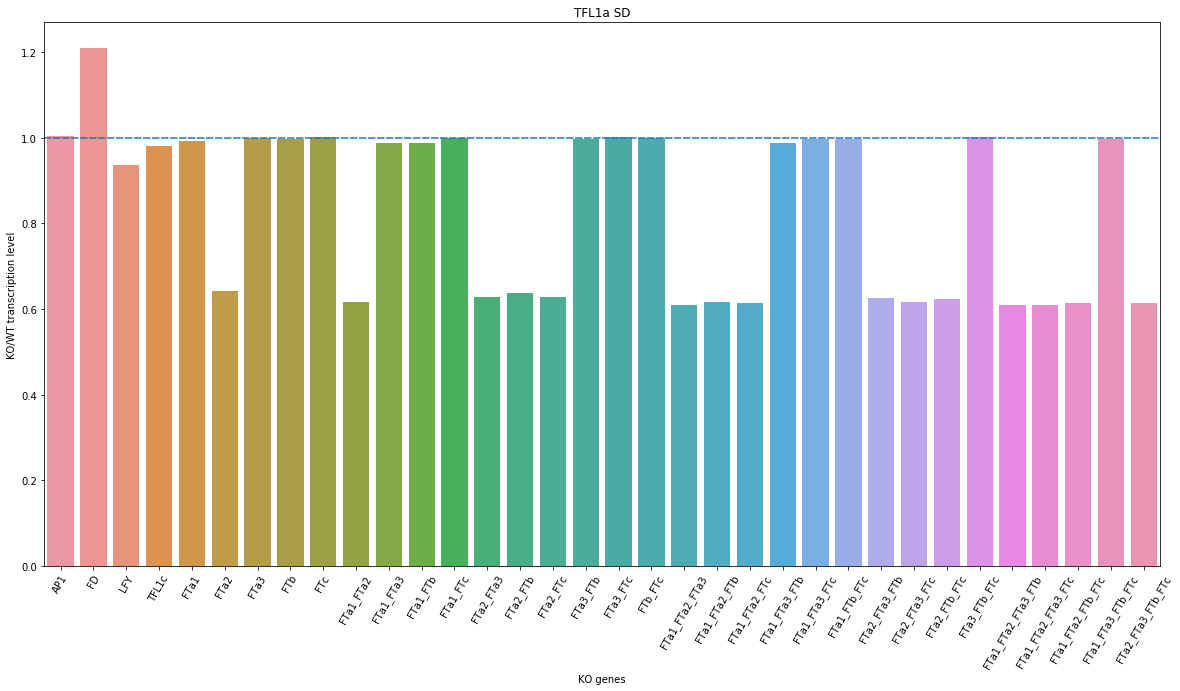

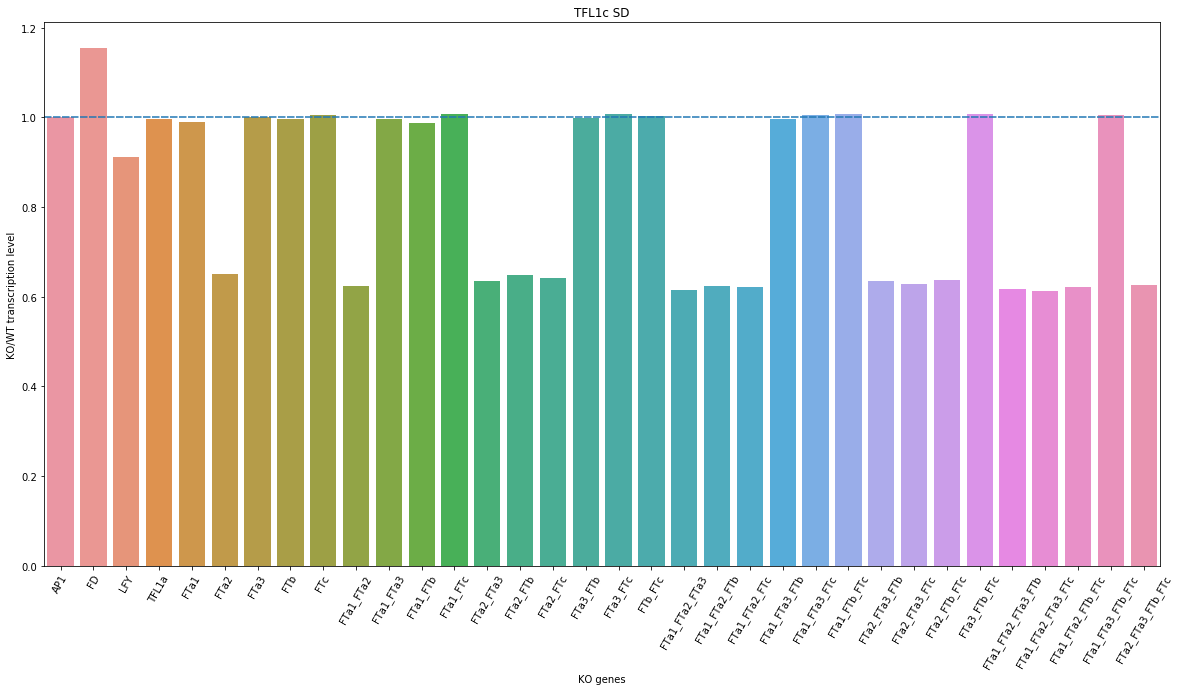

In [6]:
AUC_barplots(AUC)

In [ ]:
for f in ['FTb', 'FTa1', 'FTa3', 'FTa1_FTb']:
    myplot = sns.barplot(y = (AUC.T.loc[f,]/AUC.T.loc['WT',]).tolist(), x = AUC.T.columns)
    plt.xticks(rotation=60)
    myplot.axes.axhline(1, dashes=(5, 1))
    plt.title(f)
    plt.show()

# Save and load the model

In [83]:
dill.dump_session('cache/RandomForest.db')

In [3]:
dill.load_session('cache/RandomForest.db')

# Some trash

In [ ]:
# import torch

In [ ]:
# model_save_name = 'RF_regressor.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# model_path = data_path + model_save_name
# torch.save(total_model.state_dict(), model_path)

In [ ]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
# def clear_log():
#     with open('results/NN/NN_log.txt', 'w') as out_file:
#         out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))